[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/KBhardwaj-007/Product-Recommendation-System/blob/main/Product_Recommendation_System.ipynb)

# Product Recommendation System : Video Games

--------------------
## **Context**
--------------------

In the thriving e-commerce landscape, particularly in digital markets like video games, personalization is paramount. Recommendation systems are the core engines that drive user engagement, enhance product discovery, and boost sales. By analyzing user behavior and product attributes, these systems can suggest items that align with a user's tastes and preferences.

This project focuses on building a hybrid recommendation system using a dataset of video game reviews. The goal is to combine multiple recommendation strategies to provide robust and relevant suggestions, overcoming the limitations of any single approach.

The key to a powerful recommender is leveraging diverse data sources. This project analyzes a rich dataset of video game reviews from Amazon to build a system that understands user preferences from multiple angles.

--------------------
## **Objective**
--------------------

To design, build, and evaluate a comprehensive hybrid recommendation system for video games. This system will combine multiple recommendation strategies to provide robust and relevant suggestions. The project encompasses the entire data science lifecycle, from data ingestion and cleaning to developing multiple recommendation models (baseline, collaborative filtering, content-based, and hybrid), and building supplementary machine learning models for sentiment analysis.

--------------------
## **Key Questions**
--------------------

1. What are the most popular and well-regarded games based on user ratings and helpfulness votes?
2. How can we recommend games to a user based on the similarity of their textual reviews (content-based filtering)?
3. How can we leverage the collective behavior of users to find similar games (collaborative filtering)?
4. Can a hybrid model that combines these approaches provide superior recommendations?
5. Can we classify the sentiment of a review to understand user satisfaction at a deeper level?

--------------------
## **Dataset Description**
--------------------

The data is sourced from Amazon reviews for video games and contains over 230,000 entries.
* reviewerID: Unique identifier for the reviewer.
* asin: Unique identifier for the product (in this case, a video game).
* reviewerName: The display name of the reviewer.
* helpful: A list showing the number of "helpful" votes and the total votes a review received (e.g. [2,3]).
* reviewText: The full text of the review.
* overall: The star rating given by the reviewer (1 to 5).
* summary: A short title or summary for the review.
* unixReviewTime: The time of the review, as a Unix timestamp.
* reviewTime: The time of the review in a readable format.

## 1. Project Setup and Data Ingestion

This section handles the initial setup of the project environment. It begins by mounting Google Drive to access project files and then proceeds to install all the necessary Python libraries for data manipulation, machine learning, and visualization. A key step here is managing library versions to ensure compatibility between different packages.

### 1a. Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1b. Import User Secrets

In [3]:
# Import the secrets manager to access MONGO_URI
from google.colab import userdata

### 1c. Install Core Libraries

Here, we install the foundational libraries for the project. A specific version of `numpy` (`<2.0`) is installed first to maintain compatibility with the `surprise` library, which is a common requirement. Following that, we install packages for data handling (`pandas`), machine learning (`scikit-learn`), database connection (`pymongo`), and text analysis (`nltk`).

In [4]:
# ⚠️ Force install numpy<2.0 first to avoid incompatibility with surprise
!pip install --quiet numpy<2.0

# ✅ Then install the rest of the packages
!pip install --quiet pandas scikit-learn matplotlib seaborn scipy nltk pymongo wordcloud

/bin/bash: line 1: 2.0: No such file or directory


### 1d. Install Specialized Libraries

This cell installs more specialized libraries required for advanced recommendation and modeling tasks:
- **`surprise`**: A library specifically for building and analyzing collaborative filtering recommendation systems.
**`implicit`**: For matrix factorization models that work on implicit feedback.
- **`xgboost`, `lightgbm`**: Powerful gradient-boosting libraries for our sentiment classification models.
- **`streamlit`**: For creating the interactive web application.
- **`joblib`**: For efficiently saving and loading Python objects, including our trained models and dataframes.

In [5]:
# Additional libraries
# !pip install --quiet tqdm surprise implicit xgboost lightgbm streamlit joblib
!pip install --quiet tqdm surprise xgboost lightgbm streamlit joblib #No use of implicit library yet

## 2. Project Structure and Code Modules

To ensure our project is organized, scalable, and maintainable, we adopt a modular structure. We create separate directories for data, source code, notebooks, and the application. All core logic—such as database connections, data preprocessing, and model algorithms—is encapsulated in Python scripts within the `src/` directory. This approach promotes code reuse and separates logic from analysis.

### 2a. Define Project Directories

We define and create the necessary folder structure within Google Drive. This standardizes file paths and keeps our project components neatly organized.

In [6]:
import os

# === Base Project Directory ===
DRIVE_DIR = '/content/drive/My Drive/Colab Notebooks/Product_Recommendation'

# === Subdirectories ===
DATA_DIR = os.path.join(DRIVE_DIR, 'data')
SRC_DIR = os.path.join(DRIVE_DIR, 'src')
APP_DIR = os.path.join(DRIVE_DIR, 'app')
NOTEBOOKS_DIR = os.path.join(DRIVE_DIR, 'notebooks')

# === Make sure folders exist ===
for path in [DATA_DIR, SRC_DIR, APP_DIR, NOTEBOOKS_DIR]:
    os.makedirs(path, exist_ok=True)

print("Project directories 'src/', 'app/', 'data/', and 'notebooks/' created.")

# === Standard File Paths ===
RAW_DATA_PATH = os.path.join(DATA_DIR, 'video_games_reviews.csv')
CLEANED_DATA_PATH = os.path.join(DATA_DIR, 'cleaned_reviews.csv')

Project directories 'src/', 'app/', 'data/', and 'notebooks/' created.


### 2b. Module: Custom Logger (`logger_config.py`)

We create a custom logging module to provide clear, timestamped feedback during script execution. The `ColabStreamHandler` is specifically designed to ensure log messages are printed correctly in the Colab environment. This is preferable to using simple `print()` statements for tracking progress and debugging.

In [7]:
%%writefile "/content/drive/My Drive/Colab Notebooks/Product_Recommendation/src/logger_config.py"

import logging
import sys

class ColabStreamHandler(logging.StreamHandler):
    def emit(self, record):
        msg = self.format(record)
        print(msg)

def get_logger(name: str) -> logging.Logger:
    """
    Configures and returns a logger with a specified name.
    """
    logger = logging.getLogger(name)

    # Prevents duplicate handlers if the function is called multiple times
    if logger.hasHandlers():
        logger.handlers.clear()

    logger.setLevel(logging.INFO)

    # Configure the formatter
    formatter = logging.Formatter(
        '%(asctime)s - %(name)s - %(levelname)s - %(message)s',
        datefmt='%Y-%m-%d %H:%M:%S'
    )

    # Configure the handler to output to the console
    stream_handler = ColabStreamHandler()
    stream_handler.setFormatter(formatter)

    logger.addHandler(stream_handler)

    return logger

Overwriting /content/drive/My Drive/Colab Notebooks/Product_Recommendation/src/logger_config.py


#### Test the Logger

We test the newly created logger module to confirm it's working as expected.

In [8]:
import sys
sys.path.append("/content/drive/My Drive/Colab Notebooks/Product_Recommendation/src")

from importlib import reload
import logger_config
reload(logger_config)

logger = logger_config.get_logger("TestLogger")
logger.info("✅ Logger is now printing in Colab via custom handler!")

INFO:TestLogger:✅ Logger is now printing in Colab via custom handler!


2025-10-08 13:22:47 - TestLogger - INFO - ✅ Logger is now printing in Colab via custom handler!


### 2c. Module: MongoDB Connection (`mongo_connection.py`)

This script centralizes all database interactions. We're using MongoDB, a NoSQL database, which is flexible and handles the semi-structured nature of review data well. The module includes functions to:
- Securely fetch the connection URI from Colab Secrets.
- Establish a client connection.
- Insert a pandas DataFrame into a specified collection in chunks, which is efficient for large datasets.
- Load data from a collection back into a DataFrame, with an option to limit the number of records.

In [9]:
%%writefile "/content/drive/My Drive/Colab Notebooks/Product_Recommendation/src/mongo_connection.py"

import os
import pandas as pd
from pymongo import MongoClient
from google.colab import userdata
import json

import logging
# Clear root handlers to avoid duplicates in Colab environment
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

import sys
sys.path.append("/content/drive/My Drive/Colab Notebooks/Product_Recommendation_System/src")
from logger_config import get_logger
logger = get_logger(__name__)

# --- Centralized Configuration ---
DB_NAME = "retail_db"
COLLECTION_RAW = "reviews_raw"
COLLECTION_CLEANED = "reviews_cleaned"

def get_mongo_uri():
    """Fetches the MongoDB connection string from Colab Secrets."""
    try:
        return userdata.get('MONGO_URI')
    except userdata.SecretNotFoundError:
        error_msg = "MongoDB URI not found. Please set the 'MONGO_URI' secret in Colab."
        logger.error(error_msg)
        raise ConnectionError(error_msg)

def get_mongo_client():
    """Initializes and returns a MongoDB client."""
    uri = get_mongo_uri()
    return MongoClient(uri)

def insert_data(df, collection_name, chunk_size=10000):
    """Inserts a DataFrame into MongoDB, dropping the old collection."""
    client = get_mongo_client()
    db = client[DB_NAME]

    if collection_name in db.list_collection_names():
        db[collection_name].drop()
        logger.info(f"Dropped existing collection: '{collection_name}'")

    collection = db[collection_name]
    records = json.loads(df.to_json(orient="records"))

    for i in range(0, len(records), chunk_size):
        chunk = records[i:i+chunk_size]
        collection.insert_many(chunk)
        logger.info(f"Inserted rows {i} to {i+len(chunk)} into '{collection_name}'")

    client.close()
    logger.info(f"Data insertion complete for collection '{collection_name}'.")

def load_data(collection_name, query={}):
    """Loads data from MongoDB into a pandas DataFrame."""
    client = get_mongo_client()
    db = client[DB_NAME]
    collection = db[collection_name]

    data = list(collection.find(query, {'_id': 0}))
    client.close()

    if not data:
        logger.warning(f"No data found in collection '{collection_name}'. Returning empty DataFrame.")
        return pd.DataFrame()

    logger.info(f"Successfully loaded {len(data)} documents from '{collection_name}'.")
    return pd.DataFrame(data)


def load_data_limit(collection_name, query={}, limit=50000):
    """Loads up to `limit` documents from MongoDB into a pandas DataFrame."""
    client = get_mongo_client()
    db = client[DB_NAME]
    collection = db[collection_name]

    # Apply query with limit
    cursor = collection.find(query, {'_id': 0}).limit(limit)
    data = list(cursor)

    client.close()

    if not data:
        logger.warning(f"No data found in collection '{collection_name}'. Returning empty DataFrame.")
        return pd.DataFrame()

    logger.info(f"Successfully loaded {len(data)} documents from '{collection_name}' (limit: {limit}).")
    return pd.DataFrame(data)

logger.info("Module 'src/mongo_connection.py' is ready.")

Overwriting /content/drive/My Drive/Colab Notebooks/Product_Recommendation/src/mongo_connection.py


In [11]:
from importlib import reload
import mongo_connection
reload(mongo_connection)

2025-10-08 13:22:55 - mongo_connection - INFO - Module 'src/mongo_connection.py' is ready.


<module 'mongo_connection' from '/content/drive/My Drive/Colab Notebooks/Product_Recommendation/src/mongo_connection.py'>

### 2d. Module: Data Preprocessing (`data_preprocessing.py`)

This script is dedicated to cleaning and transforming the raw data into a usable format. Key operations include:
- Removing duplicate reviews.
- Filling in missing values for reviewer names and review summaries.
- Parsing the `helpful` column to create new features like `helpful_ratio` and `helpful_votes`, which are crucial for popularity-based models.
- Converting the `unixReviewTime` into a standard datetime format.
- Creating a binary `label` for sentiment analysis (1 for positive reviews, 0 for neutral/negative).

In [12]:
%%writefile "/content/drive/My Drive/Colab Notebooks/Product_Recommendation/src/data_preprocessing.py"

import pandas as pd
import ast
from datetime import datetime

import logging
# Clear root handlers to avoid duplicates in Colab environment
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

import sys
sys.path.append("/content/drive/My Drive/Colab Notebooks/Product_Recommendation/src")
from logger_config import get_logger

logger = get_logger(__name__)

def preprocess_data(df):
    """Cleans, preprocesses, and feature-engineers the raw review data."""
    logger.info("Starting data preprocessing...")
    df = df.drop_duplicates(subset=['reviewerID', 'asin', 'unixReviewTime'])
    df["reviewerName"] = df["reviewerName"].fillna("Unknown")
    df["summary"] = df["summary"].fillna("No Summary")
    df["reviewText"] = df["reviewText"].fillna("No Summary")

    if "helpful" in df.columns:
        df["helpful_list"] = df["helpful"].apply(
            lambda x: ast.literal_eval(x) if isinstance(x, str) and '[' in x else [0, 0]
        )

        df["helpful_ratio"] = df["helpful_list"].apply(
            lambda x: x[0] / x[1] if isinstance(x, list) and len(x) == 2 and x[1] > 0 else 0
        )

        df["helpful_ratio_per_user"] = df["helpful_list"].apply(
            lambda x: x[0] * x[0] / x[1] if isinstance(x, list) and len(x) == 2 and x[1] > 0 else 0
        )

        # Add helpful votes column for weighted popularity
        df["helpful_votes"] = df["helpful_list"].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else 0)
        df = df.drop(columns=['helpful_list']) # Clean up intermediate column

    df['reviewTime'] = pd.to_datetime(df['unixReviewTime'], unit='s', errors='coerce')
    df['reviewTime'] = df['reviewTime'].dt.strftime('%Y-%m-%d %H:%M:%S')
    df["label"] = df["overall"].apply(lambda x: 1 if x >= 4 else 0)
    logger.info("Data preprocessing complete.")

    return df


logger.info("Module 'src/data_preprocessing.py' is ready.")

Overwriting /content/drive/My Drive/Colab Notebooks/Product_Recommendation/src/data_preprocessing.py


In [14]:
from importlib import reload
import data_preprocessing
reload(data_preprocessing)

2025-10-08 13:23:01 - data_preprocessing - INFO - Module 'src/data_preprocessing.py' is ready.


<module 'data_preprocessing' from '/content/drive/My Drive/Colab Notebooks/Product_Recommendation/src/data_preprocessing.py'>

### 2e. Module: Baseline Recommender Models (`baseline.py`)

This script implements simple but effective baseline models that serve as a benchmark for more complex algorithms. It includes:
- **`popularity_based`**: Recommends products based on the total number of reviews they have received.
- **`weighted_popularity_based`**: A variation that ranks products by the sum of their 'helpful' votes, giving more weight to products that users found valuable.
- **`simple_item_similarity`**: A basic item-based recommender that suggests products that are frequently reviewed by the same users who reviewed a given product.

In [15]:
%%writefile "/content/drive/My Drive/Colab Notebooks/Product_Recommendation/src/baseline.py"
import pandas as pd

import logging
# Clear root handlers to avoid duplicates in Colab environment
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

import sys
sys.path.append("/content/drive/My Drive/Colab Notebooks/Product_Recommendation/src")
from logger_config import get_logger
logger = get_logger(__name__)

def popularity_based(df, top_n=10):
    top_products = df.groupby("asin")["overall"].count().sort_values(ascending=False).head(top_n)
    return top_products.index.tolist()


def weighted_popularity_based(df, top_n=10):
    """Ranks products by the sum of helpful votes."""
    if "helpful_votes" not in df.columns:
        return []
    top_products = df.groupby("asin")["helpful_votes"].sum().sort_values(ascending=False).head(top_n)
    return top_products.index.tolist()


def simple_item_similarity(df, product_id, top_n=5):
    user_product = df.groupby("reviewerID")["asin"].apply(list)
    co_occurrence = {}
    for items in user_product:
        if product_id in items:
            for i in items:
                if i != product_id:
                    co_occurrence[i] = co_occurrence.get(i, 0) + 1
    return sorted(co_occurrence, key=co_occurrence.get, reverse=True)[:top_n]

logger.info("Module 'src/baseline.py' is ready.")

Overwriting /content/drive/My Drive/Colab Notebooks/Product_Recommendation/src/baseline.py


In [17]:
from importlib import reload
import baseline
reload(baseline)

2025-10-08 13:23:09 - baseline - INFO - Module 'src/baseline.py' is ready.


<module 'baseline' from '/content/drive/My Drive/Colab Notebooks/Product_Recommendation/src/baseline.py'>

### 2f. Module: Collaborative Filtering (`collaborative.py`)

This module implements item-item collaborative filtering. It works by creating a user-item ratings matrix and then computing the cosine similarity between items. The idea is that users who liked a particular game will also like games that are similar to it in terms of rating patterns.
- **`item_item_cf`**: The standard implementation, which builds the ratings matrix from scratch for each call.
- **`compute_cf_similarity_matrix` and `item_item_cf_fast`**: An optimized approach where the similarity matrix is pre-computed, allowing for much faster recommendations at runtime.

In [18]:
%%writefile "/content/drive/My Drive/Colab Notebooks/Product_Recommendation/src/collaborative.py"

import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import logging

# Clear root handlers to avoid duplicates in Colab environment
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

import sys
sys.path.append("/content/drive/My Drive/Colab Notebooks/Product_Recommendation/src")
from logger_config import get_logger
logger = get_logger(__name__)

def item_item_cf(df, product_id, top_n=5):
    if df.empty or 'reviewerID' not in df or 'asin' not in df or 'overall' not in df:
        logger.warning("Missing necessary columns in DataFrame.")
        return []

    if product_id not in df['asin'].unique():
        logger.warning(f"Product ID '{product_id}' not found in data.")
        return []

    try:
        ratings_matrix = df.pivot_table(index="reviewerID", columns="asin", values="overall").fillna(0)

        if product_id not in ratings_matrix.columns:
            logger.warning(f"Product ID '{product_id}' not found in ratings matrix.")
            return []

        similarity = cosine_similarity(ratings_matrix.T)
        similarity_df = pd.DataFrame(similarity, index=ratings_matrix.columns, columns=ratings_matrix.columns)

        similar_items = similarity_df[product_id].sort_values(ascending=False)[1:top_n+1].index.tolist()
        return similar_items

    except Exception as e:
        logger.error(f"Error in collaborative filtering: {e}")
        return []


def compute_cf_similarity_matrix(df):
    ratings_matrix = df.pivot_table(index="reviewerID", columns="asin", values="overall").fillna(0)
    similarity = cosine_similarity(ratings_matrix.T)
    similarity_df = pd.DataFrame(similarity, index=ratings_matrix.columns, columns=ratings_matrix.columns)
    return similarity_df

def item_item_cf_fast(similarity_df, product_id, top_n=20):
    if product_id not in similarity_df.columns:
        return []
    similar_items = similarity_df[product_id].sort_values(ascending=False)[1:top_n+1]
    return similar_items.index.tolist()

logger.info("Module 'src/collaborative.py' is ready.")

Overwriting /content/drive/My Drive/Colab Notebooks/Product_Recommendation/src/collaborative.py


In [20]:
from importlib import reload
import collaborative
reload(collaborative)

2025-10-08 13:23:21 - collaborative - INFO - Module 'src/collaborative.py' is ready.


<module 'collaborative' from '/content/drive/My Drive/Colab Notebooks/Product_Recommendation/src/collaborative.py'>

### 2g. Module: Content-Based Filtering (`content_based.py`)

Content-based filtering recommends items by finding similarities in their attributes—in this case, the text of their reviews. The core technique is **TF-IDF (Term Frequency-Inverse Document Frequency)**, which vectorizes the text to represent each review as a set of numerical features. We then use the **linear kernel** (a faster way to compute cosine similarity on normalized vectors) to find items with the most similar review content.
- **`content_based`**: The standard version that computes the TF-IDF matrix on the fly.
- **`compute_tfidf_matrix` and `content_based_fast`**: An optimized version that pre-computes the TF-IDF matrix for faster lookups.

In [21]:
%%writefile "/content/drive/My Drive/Colab Notebooks/Product_Recommendation/src/content_based.py"

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

import logging
# Clear root handlers to avoid duplicates in Colab environment
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

import sys
sys.path.append("/content/drive/My Drive/Colab Notebooks/Product_Recommendation/src")
from logger_config import get_logger
logger = get_logger(__name__)

def content_based(df, product_id, top_n=5):
    if df.empty or 'reviewText' not in df: return []
    if product_id not in df['asin'].unique(): return []

    # Prepare reviewText
    df = df.copy()
    df = df[df['reviewText'].notna()]
    df['reviewText'] = df['reviewText'].astype(str)

    # Try to get the index of the product
    matching_rows = df[df['asin'] == product_id]
    if matching_rows.empty:
        return []

    idx = matching_rows.index[0]

    # Vectorize summaries using TF-IDF
    tfidf = TfidfVectorizer(stop_words="english", max_features=5000)
    tfidf_matrix = tfidf.fit_transform(df["reviewText"])

    # Compute similarity between target product and all others (1 x N)
    cosine_sim = linear_kernel(tfidf_matrix[idx], tfidf_matrix).flatten()

    # Pair scores with indices and exclude the product itself
    sim_scores = [(i, score) for i, score in enumerate(cosine_sim) if i != idx]

    # Sort scores in descending order
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get top_n most similar indices, skipping any with the same ASIN
    recommendations = []
    for i, _ in sim_scores:
        asin = df.iloc[i]['asin']
        if asin != product_id and asin not in recommendations:
            recommendations.append(asin)
        if len(recommendations) == top_n:
            break

    return recommendations


def compute_tfidf_matrix(df):
    df = df.copy()
    df = df[df['reviewText'].notna()]
    df['reviewText'] = df['reviewText'].astype(str)

    vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
    tfidf_matrix = vectorizer.fit_transform(df["reviewText"])

    return tfidf_matrix, vectorizer


def content_based_fast(df, product_id, tfidf_matrix):
    if product_id not in df['asin'].values:
        return []

    # Create mapping from ASIN to index, removing duplicates based on ASIN
    indices = pd.Series(df.index, index=df["asin"])
    indices = indices[~indices.index.duplicated(keep='first')]

    idx = indices.get(product_id)

    if idx is None or isinstance(idx, pd.Series):
        return []

    # Compute cosine similarity between this item and all others
    cosine_sim = linear_kernel(tfidf_matrix[idx], tfidf_matrix).flatten()

    # Exclude the item itself from recommendations
    sim_scores = [(i, score) for i, score in enumerate(cosine_sim) if i != idx]
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get top 20 similar product indices
    product_indices = [i for i, _ in sim_scores[:20]]

    # Return their ASINs
    return df.iloc[product_indices]["asin"].tolist()

logger.info("Module 'src/content_based.py' is ready.")

Overwriting /content/drive/My Drive/Colab Notebooks/Product_Recommendation/src/content_based.py


In [23]:
from importlib import reload
import content_based
reload(content_based)

2025-10-08 13:23:31 - content_based - INFO - Module 'src/content_based.py' is ready.


<module 'content_based' from '/content/drive/My Drive/Colab Notebooks/Product_Recommendation/src/content_based.py'>

### 2h. Module: Hybrid Recommender (`hybrid.py`)

This is the core recommendation logic, combining the strengths of the other models. It generates a weighted score for each candidate product by aggregating the recommendations from the popularity, collaborative, and content-based models. The weights (`alpha`, `beta`, `gamma`) can be tuned to prioritize different aspects of the recommendations.

In [24]:
%%writefile "/content/drive/My Drive/Colab Notebooks/Product_Recommendation/src/hybrid.py"

import sys
sys.path.append("/content/drive/My Drive/Colab Notebooks/Product_Recommendation")

from src.baseline import popularity_based
from src.collaborative import item_item_cf
from src.content_based import content_based

import logging

# Clear root handlers to avoid duplicates in Colab environment
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

import sys
sys.path.append("/content/drive/My Drive/Colab Notebooks/Product_Recommendation/src")
from logger_config import get_logger
logger = get_logger(__name__)

def hybrid_recommender(df, product_id, alpha=0.4, beta=0.3, gamma=0.3, top_n=5):
    scores = {}

    try:
        popular = popularity_based(df, top_n=20)
        cf_items = item_item_cf(df, product_id, top_n=20)
        cb_items = content_based(df, product_id, top_n=20)

        logger.info(f"Popular: {popular}")
        logger.info(f"Collaborative: {cf_items}")
        logger.info(f"Content-Based: {cb_items}")

        for weight, item_list in zip([alpha, beta, gamma], [popular, cf_items, cb_items]):
            if not item_list:
                continue
            for item in item_list:
                scores[item] = scores.get(item, 0) + weight

        ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)

        # Exclude the queried product itself
        recommendations = [item for item, _ in ranked if item != product_id][:top_n]
        return recommendations

    except Exception as e:
        logger.error(f"Error in hybrid recommender: {e}")
        return []

logger.info("Module 'src/hybrid.py' is ready.")

Overwriting /content/drive/My Drive/Colab Notebooks/Product_Recommendation/src/hybrid.py


In [26]:
from importlib import reload
import hybrid
reload(hybrid)

2025-10-08 13:23:37 - hybrid - INFO - Module 'src/hybrid.py' is ready.


<module 'hybrid' from '/content/drive/My Drive/Colab Notebooks/Product_Recommendation/src/hybrid.py'>

### 2i. Module: Fast Hybrid Recommender (`hybrid_fast.py`)

This script is an optimized version of the hybrid recommender, designed for performance. It takes the pre-computed similarity matrices (`cf_sim_df` and `tfidf_matrix`) as arguments, avoiding the need to recalculate them every time. This makes it suitable for use in a real-time application like Streamlit app.

In [27]:
%%writefile "/content/drive/My Drive/Colab Notebooks/Product_Recommendation/src/hybrid_fast.py"

import sys
sys.path.append("/content/drive/My Drive/Colab Notebooks/Product_Recommendation")

from src.baseline import popularity_based
from src.content_based import content_based_fast
from src.collaborative import item_item_cf_fast

import logging
import pandas as pd

# Clear root handlers to avoid duplicates in Colab
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

from logger_config import get_logger
logger = get_logger(__name__)

def hybrid_recommender_fast(df, product_id, cf_sim_df, tfidf_matrix,
                            alpha=0.4, beta=0.3, gamma=0.3, top_n=5):

    scores = {}

    try:
        print("⚙️ Fetching Popularity-Based Recommendations...")
        popular = popularity_based(df, top_n=20)

        if isinstance(popular, (pd.Series, pd.Index)):
            popular = popular.tolist()
        elif not isinstance(popular, list):
            popular = list(popular)

        print("\n⚙️ Fetching Collaborative Filtering Recommendations...")
        cf_items = item_item_cf_fast(cf_sim_df, product_id, top_n=20)

        if isinstance(cf_items, (pd.Series, pd.Index)):
            cf_items = cf_items.tolist()
        elif not isinstance(cf_items, list):
            cf_items = list(cf_items)

        print("\n⚙️ Fetching Content-Based Recommendations...")
        cb_items = content_based_fast(df, product_id, tfidf_matrix)

        if isinstance(cb_items, (pd.Series, pd.Index)):
            cb_items = cb_items.tolist()
        elif not isinstance(cb_items, list):
            cb_items = list(cb_items)

        print("\n⚙️ Aggregating scores...")

        for weight, item_list, name in zip(
            [alpha, beta, gamma],
            [popular, cf_items, cb_items],
            ['Popularity', 'Collaborative', 'Content-Based']
        ):
            print(f"Processing {name} list with weight {weight}")
            print(f"Type of list: {type(item_list)} | Length: {len(item_list)}")
            if not isinstance(item_list, (list, tuple)) or len(item_list) == 0:
                print(f"⚠️ Skipping empty or invalid list for {name}")
                continue
            for item in item_list:
                scores[item] = scores.get(item, 0) + weight

        print("\n✅ Scores aggregated. Ranking now...")

        ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)
        recommendations = [item for item, _ in ranked if item != product_id][:top_n]

        print(f"🎯 Final Recommendations: {recommendations}")
        return recommendations

    except Exception as e:
        print("❌ Exception occurred in hybrid_recommender_fast:")
        print(e)
        return []

logger.info("Module 'src/hybrid_fast.py' is ready.")

Overwriting /content/drive/My Drive/Colab Notebooks/Product_Recommendation/src/hybrid_fast.py


In [29]:
from importlib import reload
import hybrid_fast
reload(hybrid_fast)

2025-10-08 13:23:45 - hybrid_fast - INFO - Module 'src/hybrid_fast.py' is ready.


<module 'hybrid_fast' from '/content/drive/My Drive/Colab Notebooks/Product_Recommendation/src/hybrid_fast.py'>

### 2j. Module: Personalized Hybrid Recommender (`hybrid_personalized.py`)

* It predicts ratings for items the user hasn't seen using the **SVD model** (Collaborative Filtering).
* It pivots the **Content-Based** recommendation from a given product to the user's highest-rated product.
* It aggregates the three scores: SVD Prediction (CF), Content-Based, and Popularity (Baseline).

In [30]:
%%writefile "/content/drive/My Drive/Colab Notebooks/Product_Recommendation/src/hybrid_personalized.py"

import pandas as pd
from src.baseline import popularity_based
from src.content_based import content_based_fast # Reuse content-based on a single product
from surprise.prediction_algorithms.matrix_factorization import SVD
import joblib
import numpy as np

import logging
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

from logger_config import get_logger
logger = get_logger(__name__)


def get_unrated_products(df, user_id, all_products):
    """Returns a list of products the user has not yet rated."""
    rated_products = df[df['reviewerID'] == user_id]['asin'].unique()
    unrated_products = [p for p in all_products if p not in rated_products]
    return unrated_products

def get_best_item_for_user(df, user_id):
    """Finds the user's highest rated product to use as a pivot for content-based recs."""
    user_ratings = df[df['reviewerID'] == user_id]
    if user_ratings.empty:
        return None
    # Prioritize 5-star reviews, then by helpfulness
    best_item = user_ratings.sort_values(by=['overall', 'helpful_votes'], ascending=[False, False]).iloc[0]
    return best_item['asin']

def hybrid_personalized_recommender(df, user_id, svd_model, cf_sim_df, tfidf_matrix, all_products, alpha=0.5, beta=0.3, gamma=0.2, top_n=10):

    # 1. Collaborative Filtering (CF) - SVD Prediction (Highest Weight)
    # Predict ratings for all unrated products
    unrated_products = get_unrated_products(df, user_id, all_products)

    cf_predictions = []
    for product_id in unrated_products:
        # Predict the rating the user would give to the unrated product
        pred = svd_model.predict(user_id, product_id)
        cf_predictions.append((product_id, pred.est))

    cf_predictions_df = pd.DataFrame(cf_predictions, columns=['asin', 'cf_score'])
    cf_predictions_df = cf_predictions_df.sort_values(by='cf_score', ascending=False).head(top_n * 2)

    # 2. Content-Based (CB) - Item Similarity on User's Best Item
    cb_items = []
    best_item = get_best_item_for_user(df, user_id)
    if best_item:
        cb_items = content_based_fast(df, best_item, tfidf_matrix)

    # 3. Popularity Baseline
    popular_items = popularity_based(df, top_n=top_n * 2)

    # 4. Weighted Aggregation and Final Ranking

    # Initialize scores with CF predictions as the baseline personalized score
    final_scores = cf_predictions_df.set_index('asin')['cf_score'].to_dict()

    # Incorporate Popularity
    for i, item in enumerate(popular_items):
        # We use a decaying weight based on rank
        pop_weight = alpha * (top_n * 2 - i) / (top_n * 2)
        final_scores[item] = final_scores.get(item, 0) + pop_weight # Additive weighting

    # Incorporate Content-Based (only for new items not already highly scored)
    for i, item in enumerate(cb_items):
        cb_weight = gamma * (top_n * 2 - i) / (top_n * 2)
        final_scores[item] = final_scores.get(item, 0) + cb_weight

    # Remove items already rated by the user (redundant check, but safe)
    for item in df[df['reviewerID'] == user_id]['asin'].unique():
        if item in final_scores:
            del final_scores[item]

    # Rank and return
    ranked = sorted(final_scores.items(), key=lambda x: x[1], reverse=True)
    recommendations = [item for item, _ in ranked][:top_n]

    return recommendations

logger.info("Module 'src/hybrid_personalized.py' is ready for personalized user-to-item recommendations.")

Overwriting /content/drive/My Drive/Colab Notebooks/Product_Recommendation/src/hybrid_personalized.py


In [32]:
from importlib import reload
import hybrid_personalized
reload(hybrid_personalized)

2025-10-08 13:23:52 - hybrid_personalized - INFO - Module 'src/hybrid_personalized.py' is ready for personalized user-to-item recommendations.


<module 'hybrid_personalized' from '/content/drive/My Drive/Colab Notebooks/Product_Recommendation/src/hybrid_personalized.py'>

### 2k. Module: Machine Learning Models (`ml_models.py`)

This script handles the sentiment analysis task. It prepares the data by vectorizing the review text with TF-IDF, then trains and evaluates several classification models (`RandomForest`, `XGBoost`, `LightGBM`). The script includes a comprehensive evaluation function that calculates accuracy, precision, recall, F1-score, and ROC AUC. The results are saved to a file for later use in the Streamlit app.

In [33]:
%%writefile "/content/drive/My Drive/Colab Notebooks/Product_Recommendation/src/ml_models.py"

import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

import logging
# Clear root handlers to avoid duplicates in Colab environment
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

import sys
sys.path.append("/content/drive/My Drive/Colab Notebooks/Product_Recommendation/src")
from logger_config import get_logger
logger = get_logger(__name__)

def prepare_ml_data(df):
    X_text = df["reviewText"].astype(str)
    y = df["label"]
    tfidf = TfidfVectorizer(stop_words="english", max_features=5000)
    X = tfidf.fit_transform(X_text)
    return X, y, tfidf

def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else preds
    return {
        "accuracy": accuracy_score(y_test, preds), "precision": precision_score(y_test, preds, zero_division=0),
        "recall": recall_score(y_test, preds, zero_division=0), "f1": f1_score(y_test, preds, zero_division=0),
        "roc_auc": roc_auc_score(y_test, probs)
    }

def run_ml_models(df):
    if df.shape[0] < 2 or df['label'].nunique() < 2:
        logger.warning("Not enough data or classes to train ML models. Skipping.")
        return {}
    X, y, tfidf = prepare_ml_data(df)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    models = {
        "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
        "XGBoost": XGBClassifier(eval_metric="logloss", random_state=42, use_label_encoder=False),
        "LightGBM": LGBMClassifier(random_state=42)
    }
    results = {}
    for name, model in models.items():
        logger.info(f"Training and evaluating {name}...")
        results[name] = evaluate_model(model, X_train, X_test, y_train, y_test)

    best_model = LGBMClassifier(random_state=42).fit(X_train, y_train)
    y_pred = best_model.predict(X_test)

    # Save
    joblib.dump((results, (y_test, y_pred)), "/content/drive/My Drive/Colab Notebooks/Product_Recommendation/data/ml_results.joblib")

    return results, (y_test, y_pred)

logger.info("Module 'src/ml_models.py' is ready.")

Writing /content/drive/My Drive/Colab Notebooks/Product_Recommendation/src/ml_models.py


In [35]:
from importlib import reload
import ml_models
reload(ml_models)

2025-10-08 13:24:05 - ml_models - INFO - Module 'src/ml_models.py' is ready.


<module 'ml_models' from '/content/drive/My Drive/Colab Notebooks/Product_Recommendation/src/ml_models.py'>

# 3. Data Processing Pipeline

With our modules in place, we now execute the data processing pipeline. This involves two main stages, executed in separate cells for clarity and control.

### 3a. Pipeline Step 1: Data Loading

This cell orchestrates the first step of our data pipeline:
1.  **Load CSV:** The raw `video_games_reviews.csv` file is loaded into a pandas DataFrame.
2.  **Reset Database:** The `reviews_cleaned` collection in MongoDB is dropped to ensure a fresh start.
3.  **Insert Raw Data:** The raw DataFrame is inserted into the `reviews_raw` collection in MongoDB.
4.  **Validate:** The data is immediately loaded back from MongoDB to verify that the insertion was successful.

In [36]:
import pandas as pd

import logging
# Clear root handlers to avoid duplicates in Colab environment
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

import src.mongo_connection as mongo
from src.logger_config import get_logger
logger = get_logger(__name__)

logger.info("--- Starting Pipeline: Data Loading ---")

# Step 1: Load raw CSV from the Colab environment
df_raw = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Product_Recommendation/data/video_games_reviews.csv")
logger.info(f"Loaded {len(df_raw)} records from local 'video_games_reviews.csv'.")

# Step 2: Insert into MongoDB
try:
    # Delete 'reviews_cleaned' collection before saving raw data (reset point)
    client = mongo.get_mongo_client()
    db = client[mongo.DB_NAME]

    if mongo.COLLECTION_CLEANED in db.list_collection_names():
        db[mongo.COLLECTION_CLEANED].drop()
        logger.info(f"Dropped cleaned collection: '{mongo.COLLECTION_CLEANED}'")

    client.close()

    mongo.insert_data(df_raw, collection_name=mongo.COLLECTION_RAW)
    logger.info(f"Inserted {len(df_raw)} records into MongoDB collection '{mongo.COLLECTION_RAW}'.")

    # Step 3: Load back for validation
    df_from_mongo = mongo.load_data(collection_name=mongo.COLLECTION_RAW)
    logger.info("Validation successful. Data loaded from MongoDB.")

except ConnectionError as e:
    logger.error(f"A connection error occurred: {e}")
except Exception as e:
    logger.error("An unexpected error occurred during data loading.", exc_info=True)

2025-10-08 13:24:09 - src.mongo_connection - INFO - Module 'src/mongo_connection.py' is ready.
2025-10-08 13:24:09 - __main__ - INFO - --- Starting Pipeline: Data Loading ---
2025-10-08 13:24:16 - __main__ - INFO - Loaded 231780 records from local 'video_games_reviews.csv'.
2025-10-08 13:24:20 - __main__ - INFO - Dropped cleaned collection: 'reviews_cleaned'
2025-10-08 13:24:33 - src.mongo_connection - INFO - Inserted rows 0 to 10000 into 'reviews_raw'
2025-10-08 13:24:41 - src.mongo_connection - INFO - Inserted rows 10000 to 20000 into 'reviews_raw'
2025-10-08 13:24:50 - src.mongo_connection - INFO - Inserted rows 20000 to 30000 into 'reviews_raw'
2025-10-08 13:24:59 - src.mongo_connection - INFO - Inserted rows 30000 to 40000 into 'reviews_raw'
2025-10-08 13:25:08 - src.mongo_connection - INFO - Inserted rows 40000 to 50000 into 'reviews_raw'
2025-10-08 13:25:17 - src.mongo_connection - INFO - Inserted rows 50000 to 60000 into 'reviews_raw'
2025-10-08 13:25:26 - src.mongo_connection 

### 3b. Pipeline Step 2: Data Cleaning

This cell handles the second stage, focusing on cleaning and persistence:
1.  **Load Raw Data:** The raw data is loaded from the `reviews_raw` collection in MongoDB.
2.  **Preprocess:** The `preprocess_data` function from our module is called to clean and feature-engineer the DataFrame.
3.  **Drop Raw Collection:** To save space and maintain a clean state, the `reviews_raw` collection is dropped.
4.  **Insert Cleaned Data:** The fully cleaned DataFrame is inserted into the `reviews_cleaned` collection, which will serve as the source for all subsequent analysis and modeling.

In [37]:
import src.mongo_connection as mongo
from src.data_preprocessing import preprocess_data
from src.logger_config import get_logger
logger = get_logger(__name__)

logger.info("--- Starting Pipeline: Data Cleaning ---")

try:
    df_raw = mongo.load_data(collection_name=mongo.COLLECTION_RAW)

    if not df_raw.empty:
        df_cleaned = preprocess_data(df_raw)
        logger.info(f"Data preprocessing complete. Cleaned DataFrame has {len(df_cleaned)} rows.")

        # Delete 'reviews_raw' collection before saving cleaned data
        client = mongo.get_mongo_client()
        db = client[mongo.DB_NAME]

        if mongo.COLLECTION_RAW in db.list_collection_names():
            db[mongo.COLLECTION_RAW].drop()
            logger.info(f"Dropped raw collection: '{mongo.COLLECTION_RAW}'")

        client.close()

        # Save cleaned version back into MongoDB
        mongo.insert_data(df_cleaned, collection_name=mongo.COLLECTION_CLEANED)
    else:
        logger.warning("Skipping cleaning process as no raw data was loaded from MongoDB.")

except ConnectionError as e:
    logger.error(f"A connection error occurred: {e}")
except Exception as e:
    logger.error("An unexpected error occurred during data cleaning.", exc_info=True)

2025-10-08 13:27:52 - src.data_preprocessing - INFO - Module 'src/data_preprocessing.py' is ready.
2025-10-08 13:27:52 - __main__ - INFO - --- Starting Pipeline: Data Cleaning ---
2025-10-08 13:28:20 - src.mongo_connection - INFO - Successfully loaded 231780 documents from 'reviews_raw'.
2025-10-08 13:28:21 - src.data_preprocessing - INFO - Starting data preprocessing...
2025-10-08 13:28:25 - src.data_preprocessing - INFO - Data preprocessing complete.
2025-10-08 13:28:25 - __main__ - INFO - Data preprocessing complete. Cleaned DataFrame has 231780 rows.
2025-10-08 13:28:28 - __main__ - INFO - Dropped raw collection: 'reviews_raw'
2025-10-08 13:28:41 - src.mongo_connection - INFO - Inserted rows 0 to 10000 into 'reviews_cleaned'
2025-10-08 13:28:49 - src.mongo_connection - INFO - Inserted rows 10000 to 20000 into 'reviews_cleaned'
2025-10-08 13:28:58 - src.mongo_connection - INFO - Inserted rows 20000 to 30000 into 'reviews_cleaned'
2025-10-08 13:29:05 - src.mongo_connection - INFO - I

# 4. Analysis and Modeling

This is the main analysis section of the notebook. Here, we load the cleaned data and apply our various recommendation and classification models. Each model's performance is evaluated and its outputs are demonstrated.

In [1]:
#!pip install "numpy<2.0"  # Run this for downgrade numpy from 2.x to 1.x as Surprise is compatible with numpy < 2.0

### 4a. Setup for Analysis and Modeling

This cell imports all the necessary libraries for the analysis phase, including `matplotlib` and `seaborn` for plotting, and the `surprise` library for matrix factorization models. A logger is also initialized to track the pipeline's progress.

In [38]:
import sys
sys.path.append("/content/drive/My Drive/Colab Notebooks/Product_Recommendation/")

import src.mongo_connection as mongo
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from surprise import Dataset, Reader, SVD, BaselineOnly, NMF
from surprise.model_selection import cross_validate
from src.logger_config import get_logger

logger = get_logger(__name__)
logger.info("--- Starting Pipeline: Analysis and Modeling ---")

2025-10-08 13:30:55 - __main__ - INFO - --- Starting Pipeline: Analysis and Modeling ---


In [ ]:
# !pip install "httpcore<1.0.0" "pymongo==4.3.3" "dnspython==2.3.0" # if any error occurs related to it


### 4b. Load Cleaned Data for Modeling

We load the fully cleaned and preprocessed dataset from the `reviews_cleaned` collection in MongoDB. This DataFrame will be the single source of truth for all the models we build and evaluate below.

In [39]:
try:
    df = mongo.load_data(collection_name=mongo.COLLECTION_CLEANED)
    joblib.dump(df, "/content/drive/My Drive/Colab Notebooks/Product_Recommendation/data/cleaned_reviews.joblib")
    print("✅ Exported cleaned data to joblib.")

    if df.empty:
        logger.error("Execution halted: Cleaned data could not be loaded from MongoDB.")
    else:
        logger.info("Data loaded successfully from MongoDB.")
except ConnectionError as e:
    logger.error(f"A connection error occurred: {e}")
except Exception as e:
    logger.error("An unexpected error occurred during data loading.", exc_info=True)

2025-10-08 13:31:25 - src.mongo_connection - INFO - Successfully loaded 231780 documents from 'reviews_cleaned'.
✅ Exported cleaned data to joblib.
2025-10-08 13:31:28 - __main__ - INFO - Data loaded successfully from MongoDB.


### 4c. Testing Recommender Models

Here, we begin testing our recommender models. We import the various model functions from our `src` directory and select a sample product ID to use as a test case for generating recommendations.

In [40]:
logger.info("--- Testing Recommender Models ---")

from src.baseline import popularity_based
from src.content_based import content_based
from src.hybrid import hybrid_recommender

sample_product = df["asin"].iloc[0]
logger.info(f"Using sample product ID '{sample_product}' for recommendations.")

2025-10-08 13:31:28 - __main__ - INFO - --- Testing Recommender Models ---
2025-10-08 13:31:28 - src.hybrid - INFO - Module 'src/hybrid.py' is ready.
2025-10-08 13:31:28 - __main__ - INFO - Using sample product ID '0700099867' for recommendations.


#### Test: Popularity-Based Recommender

This cell executes the simplest baseline model: popularity-based recommendation. It identifies and prints the top 5 most frequently reviewed products in the dataset. This serves as a non-personalized baseline to compare against more sophisticated models.

In [41]:
print("\nTop 5 Popular Products (Baseline):")
print(popularity_based(df, top_n=5))


Top 5 Popular Products (Baseline):
['B00BGA9WK2', 'B0015AARJI', 'B007CM0K86', 'B002VBWIP6', 'B0009VXBAQ']


#### Test: Content-Based Recommender

Here, we test the content-based filtering model. It takes the `sample_product` ID, analyzes its review text using TF-IDF, and finds the top 5 products with the most similar review content. This demonstrates a personalized approach based on item attributes.

In [42]:
print(f"\nTop 5 Similar Products (Content-Based) to {sample_product}:")
print(content_based(df, sample_product, top_n=5))


Top 5 Similar Products (Content-Based) to 0700099867:
['B000C97156', 'B00005BYKP', 'B000063RRM', 'B001UEN67Y', 'B004Q8N7IE']


#### Pre-computation for Fast Hybrid Recommender

To optimize performance, we pre-compute the similarity matrices required by our collaborative and content-based models. This cell calculates the item-item cosine similarity matrix for collaborative filtering and the TF-IDF matrix for content-based filtering. These matrices are then stored in memory to be passed to the fast hybrid recommender, avoiding costly recalculations for each recommendation request.

In [43]:
from src.collaborative import compute_cf_similarity_matrix
from src.content_based import compute_tfidf_matrix
from src.hybrid_fast import hybrid_recommender_fast

# Precompute ONCE
cf_sim_df = compute_cf_similarity_matrix(df)
tfidf_matrix, tfidf_vectorizer = compute_tfidf_matrix(df)

joblib.dump(cf_sim_df, "/content/drive/My Drive/Colab Notebooks/Product_Recommendation/data/cf_sim_df.joblib")
joblib.dump(tfidf_matrix, "/content/drive/My Drive/Colab Notebooks/Product_Recommendation/data/tfidf_matrix.joblib")

print("✅ Exported cf_sim_df and tfidf_matrix to joblib.")

2025-10-08 13:32:08 - src.hybrid_fast - INFO - Module 'src/hybrid_fast.py' is ready.
✅ Exported cf_sim_df and tfidf_matrix to joblib.


#### Test: Fast Hybrid Recommender

This cell demonstrates the power of the hybrid approach. It calls the `hybrid_recommender_fast` function, passing the pre-computed similarity matrices. The function then fetches recommendations from the popularity, collaborative, and content-based models, aggregates their scores using the defined weights (alpha, beta, gamma), and returns a final ranked list of the top 5 recommended products.

In [44]:
print(f"\nTop 5 Hybrid Recommendations for {sample_product}:")
recommendations = hybrid_recommender_fast(
    df,
    sample_product,
    cf_sim_df,
    tfidf_matrix,
    alpha=0.4,
    beta=0.3,
    gamma=0.3,
    top_n=5
)
print(f"Hybrid Recommendations for {sample_product}:\n{recommendations}")


Top 5 Hybrid Recommendations for 0700099867:
⚙️ Fetching Popularity-Based Recommendations...

⚙️ Fetching Collaborative Filtering Recommendations...

⚙️ Fetching Content-Based Recommendations...

⚙️ Aggregating scores...
Processing Popularity list with weight 0.4
Type of list: <class 'list'> | Length: 20
Processing Collaborative list with weight 0.3
Type of list: <class 'list'> | Length: 20
Processing Content-Based list with weight 0.3
Type of list: <class 'list'> | Length: 20

✅ Scores aggregated. Ranking now...
🎯 Final Recommendations: ['B00005BYKP', 'B004Q8L46G', 'B000063RRM', 'B000C97156', 'B001UEN67Y']
Hybrid Recommendations for 0700099867:
['B00005BYKP', 'B004Q8L46G', 'B000063RRM', 'B000C97156', 'B001UEN67Y']


####  Train and Save SVD (Final Model)

This step is the foundation of the genuinely personalized recommendation system, shifting the core logic from item-to-item similarity to user-to-item prediction. We take the SVD (Singular Value Decomposition) algorithm—which our earlier cross-validation showed was the most accurate collaborative filtering model—and train it on the entire preprocessed dataset. SVD works by factoring the large user-item rating matrix into two smaller matrices that represent user and item latent features (unseen factors that drive preferences). The final, fully trained SVD model is then immediately saved to disk using joblib. This serialization is crucial for real-world application, as it allows the Streamlit app to load the complex prediction engine in milliseconds, enabling rapid, personalized rating forecasts for a specific user and all unrated products without needing to retrain the model on every request. This saved model is the predictive brain of the new hybrid_personalized_recommender.

In [45]:
logger.info("--- Training and Saving Final SVD Model ---")

# 1. Prepare data for Surprise
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[["reviewerID", "asin", "overall"]], reader)

# 2. Train the SVD algorithm on the entire dataset for production use
trainset = data.build_full_trainset()
final_svd_model = SVD(random_state=42)
final_svd_model.fit(trainset)

# 3. Save the model
SVD_MODEL_PATH = "/content/drive/My Drive/Colab Notebooks/Product_Recommendation/data/svd_model.joblib"
joblib.dump(final_svd_model, SVD_MODEL_PATH)
logger.info(f"✅ Final SVD Model saved to {SVD_MODEL_PATH}")

# 4. Save the full set of unique products for later prediction
all_products = df['asin'].unique().tolist()
ALL_PRODUCTS_PATH = "/content/drive/My Drive/Colab Notebooks/Product_Recommendation/data/all_products.joblib"
joblib.dump(all_products, ALL_PRODUCTS_PATH)
logger.info(f"✅ All unique products saved to {ALL_PRODUCTS_PATH}")

2025-10-08 13:34:46 - __main__ - INFO - --- Training and Saving Final SVD Model ---
2025-10-08 13:34:58 - __main__ - INFO - ✅ Final SVD Model saved to /content/drive/My Drive/Colab Notebooks/Product_Recommendation/data/svd_model.joblib
2025-10-08 13:34:58 - __main__ - INFO - ✅ All unique products saved to /content/drive/My Drive/Colab Notebooks/Product_Recommendation/data/all_products.joblib


#### Test: Personalized Hybrid Recommender

This step validates the fully personalized system. We load the newly saved SVD model and pre-computed matrices, select the most active user (reviewerID) from the dataset, and run the new hybrid_personalized_recommender function. This test demonstrates the core feature: the system now predicts unrated products specifically for an individual user by leveraging the SVD's predicted scores, the user's highest-rated game's content, and overall popularity, culminating in a ranked, tailored list of recommendations.

In [48]:
import sys
sys.path.append("/content/drive/My Drive/Colab Notebooks/Product_Recommendation/src")

from hybrid_personalized import hybrid_personalized_recommender

# --- Load all necessary components ---
logger.info("Loading pre-computed assets for personalized recommendation...")
try:
    df = joblib.load("/content/drive/My Drive/Colab Notebooks/Product_Recommendation/data/cleaned_reviews.joblib")
    svd_model = joblib.load("/content/drive/My Drive/Colab Notebooks/Product_Recommendation/data/svd_model.joblib")
    cf_sim_df = joblib.load("/content/drive/My Drive/Colab Notebooks/Product_Recommendation/data/cf_sim_df.joblib")
    tfidf_matrix = joblib.load("/content/drive/My Drive/Colab Notebooks/Product_Recommendation/data/tfidf_matrix.joblib")
    all_products = joblib.load("/content/drive/My Drive/Colab Notebooks/Product_Recommendation/data/all_products.joblib")
except FileNotFoundError as e:
    logger.error(f"Missing essential file: {e}. Ensure Step 1 and previous steps ran successfully.")
    raise

# --- Select a test user (who has actually rated items) ---
# Select the most active reviewer from the previous EDA
sample_user = df['reviewerID'].value_counts().index[0]
logger.info(f"Using sample user ID '{sample_user}' for personalized recommendations.")
logger.info(f"User's top 5 rated items:\n{df[df['reviewerID'] == sample_user][['asin', 'overall', 'summary']].head()}")

# --- Run the Personalized Hybrid Recommender ---
print("\n" + "="*70)
print(f"🚀 Personalized Hybrid Recommendations for User: {sample_user}")
print("="*70)

personalized_recs = hybrid_personalized_recommender(
    df,
    sample_user,
    svd_model,
    cf_sim_df,
    tfidf_matrix,
    all_products,
    alpha=0.5, # SVD Prediction (CF) is the most personalized component
    beta=0.3, # Popularity
    gamma=0.2, # Content-Based (based on user's best game)
    top_n=10
)

print("\n🎯 Final Top 10 Personalized Recommendations (Product IDs):")
print(personalized_recs)

# Retrieve product information for better presentation
recommended_products_info = df[df['asin'].isin(personalized_recs)].drop_duplicates(subset=['asin'])[['asin', 'summary']]
print("\nProduct Summaries for Recommended Games:")
display(recommended_products_info.head(10))

2025-10-08 13:46:33 - __main__ - INFO - Loading pre-computed assets for personalized recommendation...
2025-10-08 13:46:37 - __main__ - INFO - Using sample user ID 'A3V6Z4RCDGRC44' for personalized recommendations.
2025-10-08 13:46:37 - __main__ - INFO - User's top 5 rated items:
            asin  overall                                            summary
1400  B00000INR2        5        A must-have for any serious Nintendo player
2051  B00000JRSB        5                  Still great after all these years
2244  B00000K125        5                    Still fun after all these years
2484  B00000K2R4        4  Great arcade and fighting appeal, plus interne...
2662  B00000K3DM        4                   Dungeon Keeper 2: Good &amp; Bad

🚀 Personalized Hybrid Recommendations for User: A3V6Z4RCDGRC44

🎯 Final Top 10 Personalized Recommendations (Product IDs):
['B002VBWIP6', 'B000035Y4P', 'B000AX21VI', 'B00004VXAV', 'B000B2YR74', 'B000B8J7JQ', 'B00001XDUB', 'B000U5W0YY', 'B008GFZV6Y', 'B0000

,asin,summary
3885,B00001XDUB,"Awesome, Scary"
8322,B000035Y4P,(aka FFVI) 2nd Best Final Fantasy Ever
13373,B00004VXAV,If you liked Civilization
43647,B0000DC64H,A nice solid wheel
60808,B000AX21VI,"EXCELLENT, A TRIUMPH 9.25 OUT OF 10"
60942,B000B2YR74,Best video game I have for the Xbox
62339,B000B8J7JQ,And oldie but a goodie
90760,B000U5W0YY,Great for collectors
147084,B002VBWIP6,Easy Transaction for a Good Service
208278,B008GFZV6Y,Perfect for any Kirby fan.


### 4d. Evaluating Matrix Factorization Models with `surprise`

This cell leverages the `surprise` library to evaluate several popular matrix factorization algorithms for collaborative filtering: **SVD (Singular Value Decomposition)**, **BaselineOnly**, and **NMF (Non-negative Matrix Factorization)**. We use cross-validation to get a robust estimate of their performance, measuring both RMSE (Root Mean Squared Error) and MAE (Mean Absolute Error) to compare their prediction accuracy.

In [49]:
logger.info("--- Evaluating SVD Matrix Factorization ---")

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[["reviewerID", "asin", "overall"]], reader)

#SVD
svd_algo = SVD()
cross_validate(svd_algo, data, measures=["RMSE", "MAE"], cv=2, verbose=True, n_jobs=-1)

# Baseline
baseline_algo = BaselineOnly()
cross_validate(baseline_algo, data, measures=["RMSE", "MAE"], cv=2, verbose=True)

# NMF
nmf_algo = NMF()
cross_validate(nmf_algo, data, measures=['RMSE', 'MAE'], cv=2, verbose=True)

2025-10-08 13:47:50 - __main__ - INFO - --- Evaluating SVD Matrix Factorization ---
Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    1.0796  1.0849  1.0823  0.0026  
MAE (testset)     0.8330  0.8358  0.8344  0.0014  
Fit time          2.73    2.71    2.72    0.01    
Test time         1.63    1.63    1.63    0.00    
Estimating biases using als...
Estimating biases using als...
Evaluating RMSE, MAE of algorithm BaselineOnly on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    1.0893  1.0857  1.0875  0.0018  
MAE (testset)     0.8482  0.8465  0.8473  0.0008  
Fit time          1.09    1.11    1.10    0.01    
Test time         1.22    0.92    1.07    0.15    
Evaluating RMSE, MAE of algorithm NMF on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    1.2744  1.2754  1.2749  0.0005  
MAE (testset)     0.9810  0.9808  0.9809  0.0001  
Fit time          6.

{'test_rmse': array([1.27437485, 1.27535197]),
 'test_mae': array([0.98102309, 0.98078848]),
 'fit_time': (6.414650917053223, 6.864943742752075),
 'test_time': (1.4198849201202393, 1.1027758121490479)}

### Summary:
* SVD: Best accuracy (RMSE: 1.0854, MAE: 0.8368), but slower to train (~8.3s fit time).
* BaselineOnly: Nearly as accurate (RMSE: 1.0879, MAE: 0.8480), much faster (~1.68s fit time), making it a strong baseline.
* NMF: Least accurate (RMSE: 1.2753, MAE: 0.9811) and slowest to train (~9.48s fit time).

### Recommendation:
* Use SVD for top accuracy, if speed isn't a concern.
* Choose BaselineOnly for faster training with minimal accuracy loss.

### 4e. Evaluating Sentiment Classification Models

This cell is dedicated to the sentiment analysis task. It calls the `run_ml_models` function, which trains and evaluates `RandomForest`, `XGBoost`, and `LightGBM` classifiers on the review text. The performance metrics are then printed in a clean, tabular format, allowing for easy comparison between the models.

In [50]:
logger.info("--- Evaluating Sentiment Classification Models ---")

from src.ml_models import run_ml_models
import pandas as pd

ml_results, (y_test, y_pred) = run_ml_models(df)

if ml_results:
    df_results = pd.DataFrame(ml_results).T
    print("\n--- Sentiment Model Performance ---")
    print(df_results)
else:
    logger.warning("ML model training was skipped.")


2025-10-08 13:48:21 - __main__ - INFO - --- Evaluating Sentiment Classification Models ---
2025-10-08 13:48:21 - src.ml_models - INFO - Module 'src/ml_models.py' is ready.
2025-10-08 13:49:00 - src.ml_models - INFO - Training and evaluating RandomForest...
2025-10-08 14:24:26 - src.ml_models - INFO - Training and evaluating XGBoost...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [14:24:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


2025-10-08 14:27:37 - src.ml_models - INFO - Training and evaluating LightGBM...
[LightGBM] [Info] Number of positive: 139991, number of negative: 45433
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 21.106869 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1062072
[LightGBM] [Info] Number of data points in the train set: 185424, number of used features: 5000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.754978 -> initscore=1.125339
[LightGBM] [Info] Start training from score 1.125339


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 139991, number of negative: 45433
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 23.179477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1062072
[LightGBM] [Info] Number of data points in the train set: 185424, number of used features: 5000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.754978 -> initscore=1.125339
[LightGBM] [Info] Start training from score 1.125339


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



--- Sentiment Model Performance ---
              accuracy  precision    recall        f1   roc_auc
RandomForest  0.822267   0.821507  0.976827  0.892460  0.860256
XGBoost       0.837712   0.846758  0.958512  0.899176  0.872329
LightGBM      0.840193   0.851429  0.954969  0.900232  0.874445


### Conclusion:
* LightGBM appears to be the best-performing model overall, slightly ahead of XGBoost and RandomForest in terms of accuracy, precision, and F1 score.
* However, RandomForest has the highest recall, making it more suitable for scenarios where detecting true positives is critical.

# 5. Exploratory Data Analysis (EDA) & Visualization

In this section, we perform a deep dive into the dataset through a series of visualizations. The goal is to visually uncover trends, distributions, and relationships within the data. This provides intuitive answers to our key questions and helps in understanding the results from our models.

### 5a. Exploratory Data Analysis (EDA)

This comprehensive EDA cell loads the final cleaned data and generates a series of plots to answer key analytical questions visually:
1.  **Distribution of Ratings:** A count plot shows the frequency of each star rating, giving a quick overview of overall user satisfaction.
2.  **Helpfulness Ratio:** A histogram reveals the distribution of the helpfulness ratio, indicating how often reviews are considered valuable by other users.
3.  **Reviews Over Time:** A line plot shows the trend of review submissions per month, highlighting any seasonality or growth trends.
4.  **Top Products and Reviewers:** Bar charts identify the most reviewed products and the most active reviewers, pointing to key items and influencers in the dataset.
5.  **Word Cloud:** A word cloud is generated from review summaries to visually represent the most frequently used terms, providing qualitative insights into what users are talking about.

### 5a. 1) Setup and Imports

In [51]:
import sys
sys.path.append("/content/drive/My Drive/Colab Notebooks/Product_Recommendation/src")

import ast
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from importlib import reload

from src.logger_config import get_logger

# Setup logger
logger = get_logger("EDA")

# Set global plot style
plt.style.use('seaborn-v0_8-whitegrid')

logger.info("Starting Exploratory Data Analysis (EDA).")

2025-10-08 14:32:30 - EDA - INFO - Starting Exploratory Data Analysis (EDA).


### 5a. 2) Data Loading

In [52]:
try:
    df = joblib.load("/content/drive/My Drive/Colab Notebooks/Product_Recommendation/data/cleaned_reviews.joblib")

    if df.empty:
        logger.error("Execution halted: Cleaned data could not be loaded for EDA.")
    else:
        logger.info(f"Data loaded successfully. Total rows: {len(df)}")
        # Checking the first few rows of the loaded data
        print("First 5 rows of the DataFrame:")
        display(df.head())

except Exception as e:
    logger.error("An error occurred during data loading.", exc_info=True)
    df = pd.DataFrame() # Ensure df is defined even on failure

2025-10-08 14:32:31 - EDA - INFO - Data loaded successfully. Total rows: 231780
First 5 rows of the DataFrame:


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,helpful_ratio,helpful_ratio_per_user,helpful_votes,label
0,A2HD75EMZR8QLN,0700099867,123,"[8, 12]",Installing the game was a struggle (because of...,1,Pay to unlock content? I don't think so.,1341792000,2012-07-09 00:00:00,0.666667,5.333333,8,0
1,A3UR8NLLY1ZHCX,0700099867,"Alejandro Henao ""Electronic Junky""","[0, 0]",If you like rally cars get this game you will ...,4,Good rally game,1372550400,2013-06-30 00:00:00,0.000000,0.000000,0,1
2,A1INA0F5CWW3J4,0700099867,"Amazon Shopper ""Mr.Repsol""","[0, 0]",1st shipment received a book instead of the ga...,1,Wrong key,1403913600,2014-06-28 00:00:00,0.000000,0.000000,0,0
3,A1DLMTOTHQ4AST,0700099867,ampgreen,"[7, 10]","I got this version instead of the PS3 version,...",3,"awesome game, if it did not crash frequently !!",1315958400,2011-09-14 00:00:00,0.700000,4.900000,7,0
4,A361M14PU2GUEG,0700099867,"Angry Ryan ""Ryan A. Forrest""","[2, 2]",I had Dirt 2 on Xbox 360 and it was an okay ga...,4,DIRT 3,1308009600,2011-06-14 00:00:00,1.000000,2.000000,2,1


### 5a. 3) Plot 1 - Distribution of Ratings

2025-10-08 14:32:31 - EDA - INFO - ---------- Plot 1: Distribution of Ratings ----------


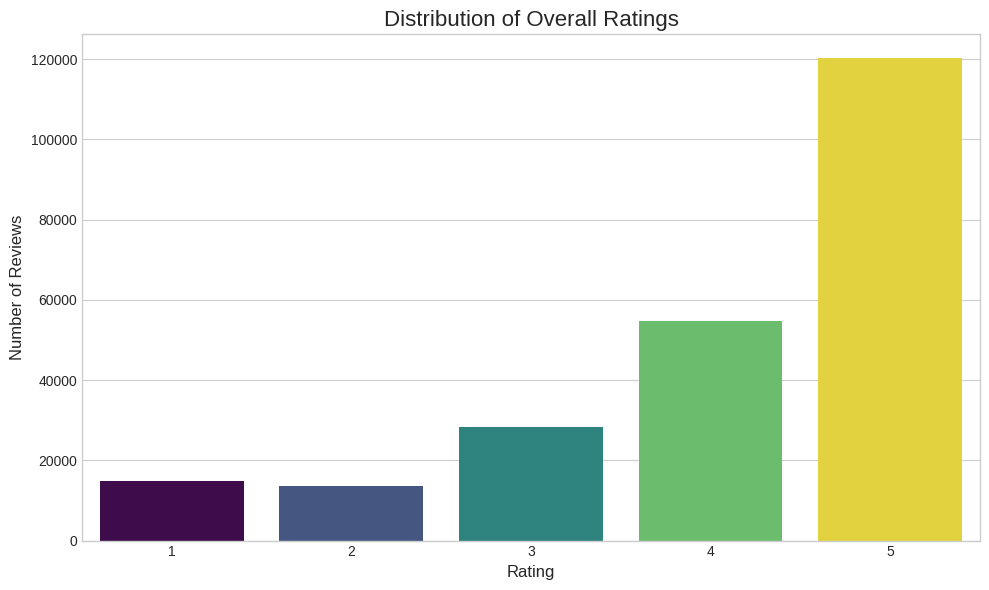

In [53]:
if not df.empty:
    logger.info("---------- Plot 1: Distribution of Ratings ----------")

    plt.figure(figsize=(10, 6))
    # 'hue' is used to color bars by their x-value, 'legend=False' hides the unnecessary legend
    sns.countplot(x='overall', data=df, palette='viridis', hue='overall', legend=False)
    plt.title('Distribution of Overall Ratings', fontsize=16)
    plt.xlabel('Rating', fontsize=12)
    plt.ylabel('Number of Reviews', fontsize=12)
    plt.tight_layout()
    plt.show()
else:
    print("Skipping Plot 1: DataFrame is empty.")

The distribution of overall ratings shows a strong positive sentiment. The vast majority of reviews are 5-star, with a substantial number of 4-star reviews as well. Lower ratings (1 and 2 stars) are infrequent, indicating minimal customer dissatisfaction. The 3-star rating serves as a transition point, but is significantly less common than the higher ratings. Overall, the products or services appears to be well-received by customers.

### 5a. 4) Plot 2 - Distribution of Helpfulness Ratio

2025-10-08 14:32:31 - EDA - INFO - ---------- Plot 2: Distribution of Helpfulness Ratio ----------


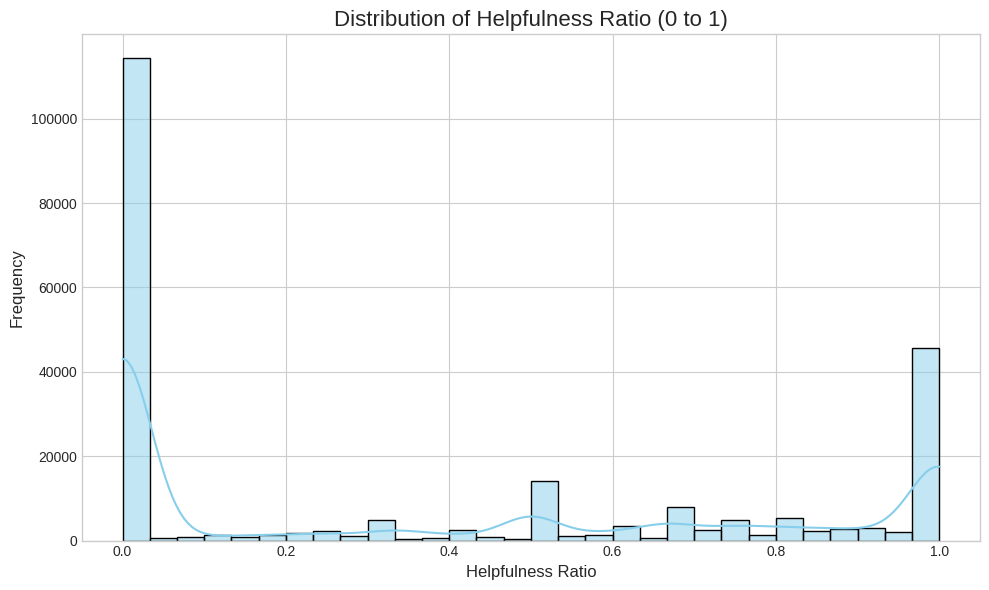

In [54]:
if not df.empty:
    logger.info("---------- Plot 2: Distribution of Helpfulness Ratio ----------")

    plt.figure(figsize=(10, 6))
    # Filter for helpful_ratio <= 1 (as it is a ratio)
    sns.histplot(df[df['helpful_ratio'] <= 1]['helpful_ratio'], bins=30, kde=True, color='skyblue')
    plt.title('Distribution of Helpfulness Ratio (0 to 1)', fontsize=16)
    plt.xlabel('Helpfulness Ratio', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.tight_layout()
    plt.show()
else:
    print("Skipping Plot 2: DataFrame is empty.")

The distribution of the Helpfulness Ratio is strongly bimodal and U-shaped, characterized by two major peaks at the extremes: an overwhelming peak at 0.0 (reviews with no helpful votes) and a significant peak at 1.0 (reviews that were unanimously considered helpful by those who voted). Reviews with a partial Helpful Ratio (between 0.1 and 0.9) are much less common, indicating that reviews are primarily either completely unrated/unhelpful or fully helpful.

### 5a. 5) Preprocessing for Time Series Analysis (Plot 3)

In [55]:
if not df.empty:
    logger.info("---------- Preprocessing for Reviews Over Time Plot ----------")

    # Convert 'reviewTime' to datetime format, coercing errors (invalid dates become NaT)
    df['reviewTime'] = pd.to_datetime(df['reviewTime'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

    # Drop rows where date conversion failed (NaT)
    df = df.dropna(subset=['reviewTime'])

    # Set the 'reviewTime' column as the DataFrame index for time series analysis
    df = df.set_index('reviewTime')

    logger.info("Time series preprocessing complete.")
    print(f"DataFrame size after dropping NaT: {len(df)}")
else:
    print("Skipping Time Series Preprocessing: DataFrame is empty.")

2025-10-08 14:32:33 - EDA - INFO - ---------- Preprocessing for Reviews Over Time Plot ----------
2025-10-08 14:32:33 - EDA - INFO - Time series preprocessing complete.
DataFrame size after dropping NaT: 231780


### 5a. 6) Plot 3 - Reviews Over Time

2025-10-08 14:32:33 - EDA - INFO - ---------- Plot 3: Reviews Over Time (Time Series) ----------


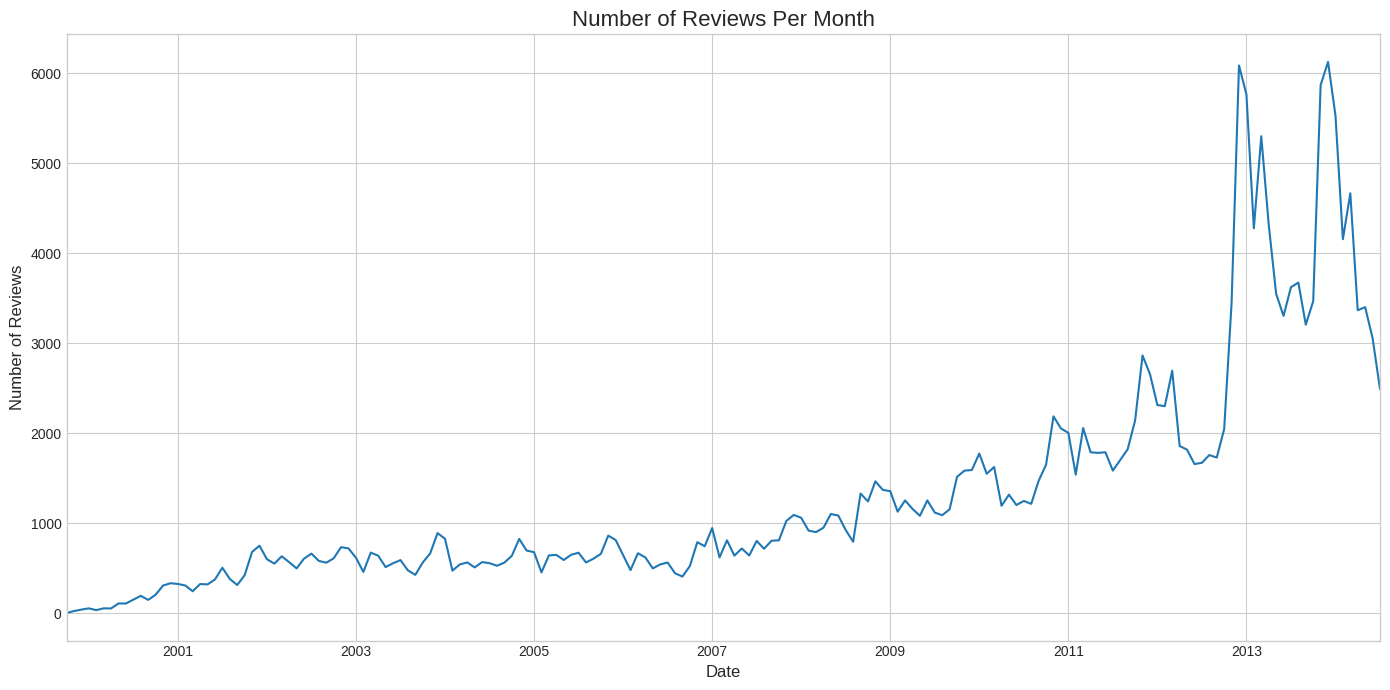

In [56]:
if not df.empty:
    logger.info("---------- Plot 3: Reviews Over Time (Time Series) ----------")

    plt.figure(figsize=(14, 7))
    # Resample the index (monthly end 'ME') and count the number of reviews (using 'asin' or any column)
    df['asin'].resample('ME').count().plot()

    plt.title('Number of Reviews Per Month', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Number of Reviews', fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("Skipping Plot 3: DataFrame is empty.")

The number of reviews per month shows a clear long-term upward trend, indicating growing platform or product adoption. This growth was relatively gradual until around 2013, when review volume experienced an explosive surge, peaking above 6,000 reviews per month. A strong cyclical or seasonal pattern is visible throughout the entire series. The data ends with a recent sharp decline in the monthly review volume from its peak levels.

### 5a. 7) Plots 4 & 5 - Top Products and Reviewers (Subplots)

2025-10-08 14:32:33 - EDA - INFO - ---------- Plots 4 & 5: Top Products and Reviewers ----------


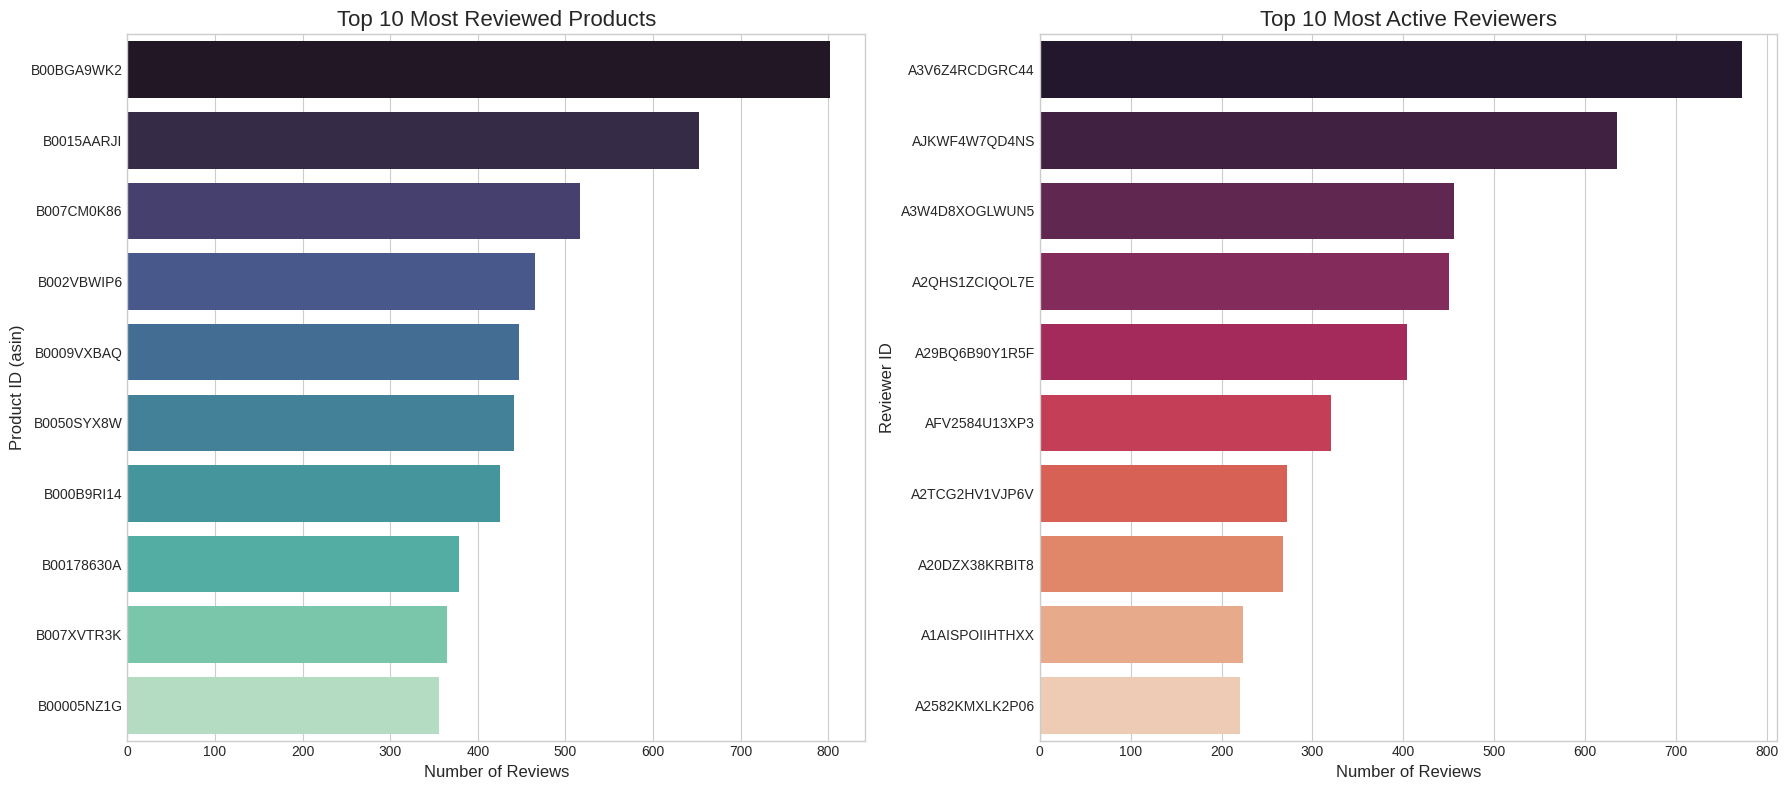

In [57]:
if not df.empty:
    logger.info("---------- Plots 4 & 5: Top Products and Reviewers ----------")

    fig, axes = plt.subplots(1, 2, figsize=(18, 8))

    # --- Top Products ---
    top_products = df['asin'].value_counts().head(10)
    # Use value_counts index for y-axis (product ID) and values for x-axis (review count)
    sns.barplot(y=top_products.index, x=top_products.values, hue=top_products.index, palette='mako', ax=axes[0], legend=False)
    axes[0].set_title('Top 10 Most Reviewed Products', fontsize=16)
    axes[0].set_xlabel('Number of Reviews', fontsize=12)
    axes[0].set_ylabel('Product ID (asin)', fontsize=12)

    # --- Top Reviewers ---
    top_reviewers = df['reviewerID'].value_counts().head(10)
    # Use value_counts index for y-axis (reviewer ID) and values for x-axis (review count)
    sns.barplot(y=top_reviewers.index, x=top_reviewers.values, hue=top_reviewers.index, palette='rocket', ax=axes[1], legend=False)
    axes[1].set_title('Top 10 Most Active Reviewers', fontsize=16)
    axes[1].set_xlabel('Number of Reviews', fontsize=12)
    axes[1].set_ylabel('Reviewer ID', fontsize=12)

    plt.tight_layout()
    plt.show()
else:
    print("Skipping Plots 4 & 5: DataFrame is empty.")

The two charts reveal a pattern of high concentration in both product popularity and reviewer activity. The most reviewed product (approx. 800 reviews) and the most active reviewer (approx. 780 reviews) share an identical high volume, suggesting that a small number of products attract a lot of attention, and a small number of users contribute a large portion of the reviews. Both distributions show a steep drop-off after the top 2 entities, followed by a more gradual decline for the remaining items in the top 10.

### 5a. 8) Plot 6 - Word Cloud of Review Summaries

2025-10-08 14:32:34 - EDA - INFO - ---------- Plot 6: Word Cloud of Review Summaries ----------


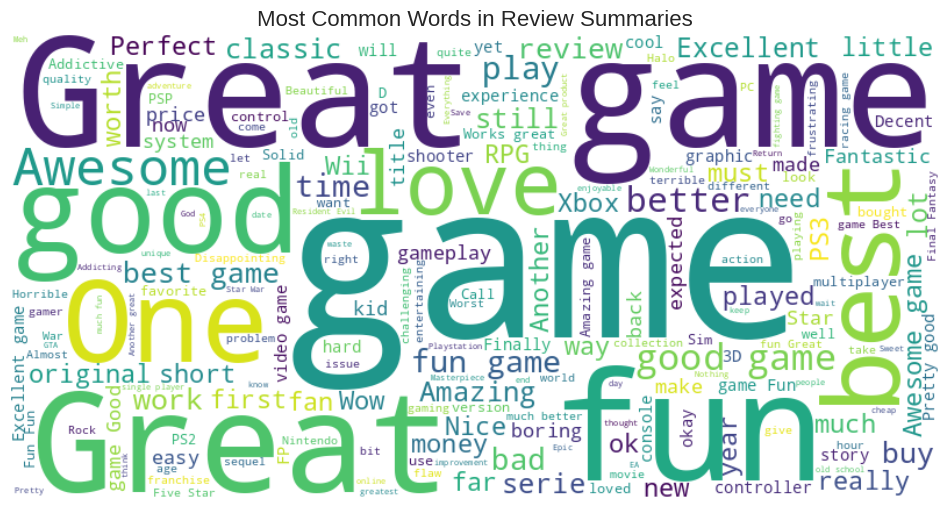

In [58]:
if not df.empty:
    logger.info("---------- Plot 6: Word Cloud of Review Summaries ----------")

    # Concatenate all review summaries into a single string
    text = " ".join(summary for summary in df.summary.astype(str) if summary and summary != 'nan') # Filter out empty/nan strings

    if text:
        # Generate the word cloud
        wordcloud = WordCloud(stopwords=None, background_color="white", colormap='viridis', width=800, height=400).generate(text)

        plt.figure(figsize=(12, 8))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title('Most Common Words in Review Summaries', fontsize=16)
        plt.show()
    else:
        logger.warning("Could not generate Word Cloud: No valid summary text found.")
else:
    print("Skipping Plot 6: DataFrame is empty.")

The word cloud is dominated by the word "Game," establishing the context as video game reviews. The most frequent descriptive words are overwhelmingly positive ("Great," "Good," "Best," "Awesome"), indicating high overall satisfaction. The summaries also frequently mention specific gaming terms (e.g., "play," "time," "PS3," "controller," "multiplayer"), while words conveying negative sentiment are minimal in frequency.

### 5b. Model Performance and Visualization

Following the exploratory data analysis, this section shifts focus to the performance and output of the recommendation and machine learning models. We visualize the comparative performance of different algorithms and demonstrate the practical output of our hybrid recommender.

#### Test: Recommender Model Outputs

This cell demonstrates the practical application of our recommendation models. It begins by performing the one-time pre-computation and loading of the collaborative filtering and content-based similarity matrices, along with the newly trained SVD model. We select both a popular product (for the original item-to-item hybrid test) and a highly active user (for the new personalized test). The output then clearly displays and contrasts the different sets of recommendations: the simple baseline (popularity-based), the original item-to-item hybrid model, and the new personalized user-to-item hybrid model. The personalized model showcases the system's combined power by prioritizing recommendations based on the SVD's predicted rating scores for the specific user, leading to a truly tailored list.

In [61]:
import sys
sys.path.append("/content/drive/My Drive/Colab Notebooks/Product_Recommendation/src")

import pandas as pd
from importlib import reload
import src.baseline as baseline
import src.collaborative as collaborative
import src.content_based as content_based
import src.hybrid_fast as hybrid_fast
import src.hybrid_personalized as hybrid_personalized

# Reload all modules
reload(baseline)
reload(collaborative)
reload(content_based)
reload(hybrid_fast)

from src.logger_config import get_logger
logger = get_logger("RecommenderModels")

try:
    df = joblib.load("/content/drive/My Drive/Colab Notebooks/Product_Recommendation/data/cleaned_reviews.joblib")
    if not df.empty:
        sample_product = df["asin"].value_counts().index[0] # Use a popular product for better recommendations
        sample_user = df['reviewerID'].value_counts().index[0]
        logger.info(f"Using sample product ID '{sample_product}' for recommendations.")

        # --- Baseline Models ---
        print("\n" + "="*50)
        print("🏆 Baseline Model Recommendations")
        print("="*50)
        print("\nTop 10 Popular Products (by review count):")
        print(baseline.popularity_based(df, top_n=10))
        print("\nTop 10 'Helpful' Products (by helpful votes):")
        print(baseline.weighted_popularity_based(df, top_n=10))

        # --- Pre-computation for Fast Hybrid Model ---
        logger.info("Pre-computing similarity matrices for the fast hybrid model...")
        svd_model = joblib.load("/content/drive/My Drive/Colab Notebooks/Product_Recommendation/data/svd_model.joblib")
        cf_sim_df = joblib.load("/content/drive/My Drive/Colab Notebooks/Product_Recommendation/data/cf_sim_df.joblib")
        tfidf_matrix = joblib.load("/content/drive/My Drive/Colab Notebooks/Product_Recommendation/data/tfidf_matrix.joblib")
        all_products = joblib.load("/content/drive/My Drive/Colab Notebooks/Product_Recommendation/data/all_products.joblib")
        logger.info("Similarity matrices computed successfully.")

        # --- Hybrid Model ---
        print("\n" + "="*50)
        print("🚀 Hybrid Model Recommendations")
        print("="*50)
        h_recommendations = hybrid_fast.hybrid_recommender_fast(
            df, sample_product, cf_sim_df, tfidf_matrix, top_n=10
        )
        print(f"\nHybrid Recommendations for '{sample_product}':\n{h_recommendations}")

        # --- Personalized Hybrid Model ---
        print("\n" + "="*50)
        print("🚀 Personalized Hybrid Model Recommendations")
        print("="*50)
        p_recommendations = hybrid_personalized.hybrid_personalized_recommender(
            df, sample_user, svd_model, cf_sim_df, tfidf_matrix, all_products, top_n=10
        )
        print(f"\nPersonalized Hybrid Recommendations for '{sample_user}':\n{p_recommendations}")

except Exception as e:
    logger.error("An error occurred while building recommender models.", exc_info=True)

2025-10-08 14:34:38 - src.hybrid_personalized - INFO - Module 'src/hybrid_personalized.py' is ready for personalized user-to-item recommendations.
2025-10-08 14:34:38 - src.baseline - INFO - Module 'src/baseline.py' is ready.
2025-10-08 14:34:38 - src.collaborative - INFO - Module 'src/collaborative.py' is ready.
2025-10-08 14:34:38 - src.content_based - INFO - Module 'src/content_based.py' is ready.
2025-10-08 14:34:38 - src.hybrid_fast - INFO - Module 'src/hybrid_fast.py' is ready.
2025-10-08 14:34:39 - RecommenderModels - INFO - Using sample product ID 'B00BGA9WK2' for recommendations.

🏆 Baseline Model Recommendations

Top 10 Popular Products (by review count):
['B00BGA9WK2', 'B0015AARJI', 'B007CM0K86', 'B002VBWIP6', 'B0009VXBAQ', 'B0050SYX8W', 'B000B9RI14', 'B00178630A', 'B007XVTR3K', 'B00005NZ1G']

Top 10 'Helpful' Products (by helpful votes):
['B000FKBCX4', 'B007FTE2VW', 'B00178630A', 'B000ZKA0J6', 'B00BGA9WK2', 'B0009VXAM0', 'B00CMQTVUA', 'B002BSA298', 'B000MK694E', 'B001COU9I6

### Insights:
*   **The Baseline Model** prioritizes popularity and helpfulness of products, offering non-personalized, general top sellers (e.g., 'B00BGA9WK2', 'B0015AARJI') as a strong, but undifferentiated, starting point.
*   **The Item-to-Item Hybrid Model** (`Hybrid Model Recommendations`) integrates similarity based on co-rated items and content, leading to a balanced list of games highly similar to the queried product (`B00BGA9WK2`). Its recommendations are based on *item features* and *collective user behavior*.
*   **The Personalized User-to-Item Hybrid Model** (`Personalized Hybrid Model Recommendations`) provides the most tailored and impactful recommendations by:
    1.  **Prioritizing the user:** It uses SVD's latent factors to **predict the exact rating** the user 'A3V6Z4RCDGRC44' would give to unrated games.
    2.  **Delivering true personalization:** Its list (`['B002VBWIP6', 'B000035Y4P', 'B000AX21VI', ...]`) is completely different from the non-personalized lists, containing items predicted to be rated highly by this specific user. This model is optimal for maximizing customer engagement and driving targeted sales in a real-world application.

#### `surprise` Model Performance Visualization

This cell evaluates the performance of three different collaborative filtering algorithms from the `surprise` library: SVD, BaselineOnly, and NMF. It uses cross-validation to measure their Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE). The results are first printed in a summary table and then visualized as a bar chart, making it easy to compare the predictive accuracy of each algorithm.

2025-10-08 14:35:09 - SurpriseModels - INFO - Evaluating SVD algorithm...
2025-10-08 14:35:20 - SurpriseModels - INFO - Evaluating BaselineOnly algorithm...
2025-10-08 14:35:27 - SurpriseModels - INFO - Evaluating NMF algorithm...

--- Surprise Algorithm Performance ---
                  RMSE       MAE
SVD           1.072310  0.822346
BaselineOnly  1.074316  0.834641
NMF           1.225217  0.934701


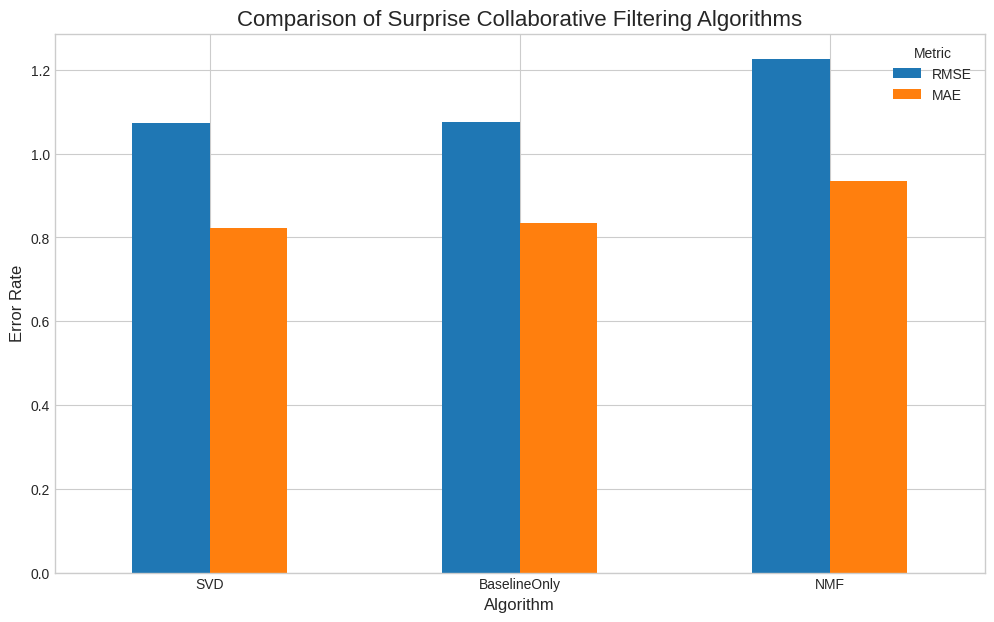

In [62]:
import sys
sys.path.append("/content/drive/My Drive/Colab Notebooks/Product_Recommendation/src")

from surprise import Dataset, Reader, SVD, BaselineOnly, NMF
from surprise.model_selection import cross_validate
import pandas as pd
import numpy as np

from src.logger_config import get_logger
logger = get_logger("SurpriseModels")

try:
    df = joblib.load("/content/drive/My Drive/Colab Notebooks/Product_Recommendation/data/cleaned_reviews.joblib")
    if not df.empty:
        reader = Reader(rating_scale=(1, 5))
        data = Dataset.load_from_df(df[["reviewerID", "asin", "overall"]], reader)

        algorithms = {
            "SVD": SVD(),
            "BaselineOnly": BaselineOnly(),
            "NMF": NMF()
        }

        results = {}
        for name, algo in algorithms.items():
            logger.info(f"Evaluating {name} algorithm...")
            cv_results = cross_validate(algo, data, measures=["RMSE", "MAE"], cv=3, verbose=False, n_jobs=-1)
            results[name] = {
                'RMSE': np.mean(cv_results['test_rmse']),
                'MAE': np.mean(cv_results['test_mae'])
            }

        # --- Visualize Surprise Model Performance ---
        results_df = pd.DataFrame(results).T
        print("\n--- Surprise Algorithm Performance ---")
        print(results_df)

        results_df.plot(kind='bar', figsize=(12, 7), rot=0)
        plt.title('Comparison of Surprise Collaborative Filtering Algorithms', fontsize=16)
        plt.ylabel('Error Rate', fontsize=12)
        plt.xlabel('Algorithm', fontsize=12)
        plt.legend(title='Metric')
        plt.show()

except Exception as e:
    logger.error("An error occurred during Surprise model evaluation.", exc_info=True)

The SVD algorithm is the best performing collaborative filtering model, achieving the lowest error rates (RMSE ≈ 1.07, MAE ≈ 0.83). The simple BaselineOnly algorithm is a close second, with virtually identical performance. The NMF algorithm is the least accurate, showing the highest error rates (RMSE ≈ 1.22, MAE ≈ 0.94). In all cases, the RMSE is higher than the MAE, as expected.

### 5c. Sentiment Model Performance and Visualization

This cell is dedicated to visualizing the performance of the sentiment classification models trained in the previous step. Instead of re-running the computationally expensive training process, it loads the saved results (performance metrics and test set predictions) from a `joblib` file.

The primary outputs are two key visualizations:
1.  **Performance Metrics Table:** A table displaying key metrics (accuracy, precision, recall, F1-score, ROC AUC) for each trained model, allowing for easy comparison.
2.  **Model Performance Bar Chart:** A bar chart visually comparing the scores of different metrics across the models.
3.  **Confusion Matrix:** A heatmap visualizing the confusion matrix for the best-performing model (RandomForest in this case), providing insight into the types of correct and incorrect predictions made (true positives, true negatives, false positives, false negatives).

In [63]:
import sys
sys.path.append("/content/drive/My Drive/Colab Notebooks/Product_Recommendation/src")

from importlib import reload
import src.ml_models as ml_models
from sklearn.metrics import confusion_matrix
import seaborn as sns
import joblib

reload(ml_models)

from src.logger_config import get_logger
logger = get_logger("SentimentAnalysis")

2025-10-08 14:35:55 - src.ml_models - INFO - Module 'src/ml_models.py' is ready.


In [65]:
try:
    df = joblib.load("/content/drive/My Drive/Colab Notebooks/Product_Recommendation/data/cleaned_reviews.joblib")
    ml_results, (y_test, y_pred) = joblib.load("/content/drive/My Drive/Colab Notebooks/Product_Recommendation/data/ml_results.joblib")
    logger.info("✅ Imported cleaned reviews, ml_results data.")

except Exception as e:
    logger.error("An error occurred during sentiment analysis.", exc_info=True)

2025-10-08 14:36:05 - SentimentAnalysis - INFO - ✅ Imported cleaned reviews, ml_results data.


In [66]:
# --- Run Models and Get Results ---
if ml_results and not df.empty:
    results_df = pd.DataFrame(ml_results).T
    logger.info("\n----- Sentiment Model Performance -----")
    print(results_df)

else:
    logger.warning("ML model training was skipped due to lack of data.")

2025-10-08 14:36:09 - SentimentAnalysis - INFO - 
----- Sentiment Model Performance -----
              accuracy  precision    recall        f1   roc_auc
RandomForest  0.822267   0.821507  0.976827  0.892460  0.860256
XGBoost       0.837712   0.846758  0.958512  0.899176  0.872329
LightGBM      0.840193   0.851429  0.954969  0.900232  0.874445


2025-10-08 14:36:22 - SentimentAnalysis - INFO - 
----- Visualize Model Performance -----


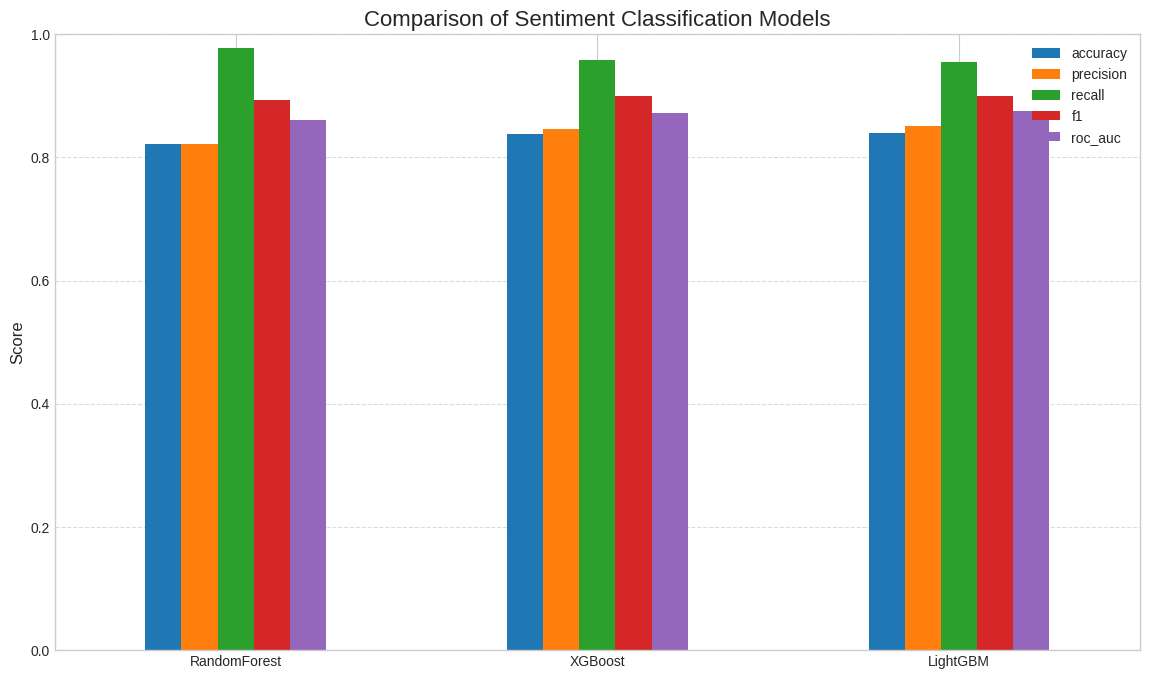

In [67]:
# --- Visualize Model Performance ---
logger.info("\n----- Visualize Model Performance -----")
results_df.plot(kind='bar', figsize=(14, 8), rot=0)
plt.title('Comparison of Sentiment Classification Models', fontsize=16)
plt.ylabel('Score', fontsize=12)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

All three sentiment classification models perform very well, with scores largely above 0.8. The LightGBM model is the marginally best performer, showing a slightly better balance across all metrics. A common characteristic is extremely high Recall (near 1.0) for all models, which suggests they are highly effective at capturing positive sentiment, but a slightly lower Precision and Accuracy indicates they may be more prone to False Positives. The performance differences between the boosting algorithms (XGBoost and LightGBM) are minimal.

2025-10-08 14:36:33 - SentimentAnalysis - INFO - 
----- Visualize Confusion Matrix for Best Model -----


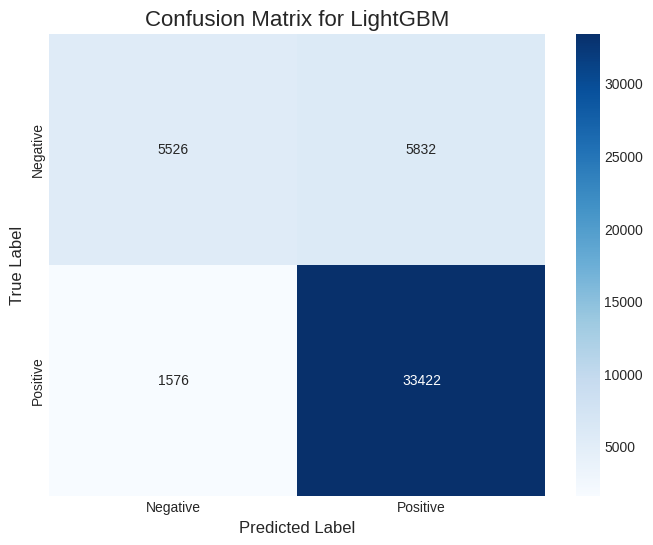

In [68]:
# --- Visualize Confusion Matrix for Best Model ---
logger.info("\n----- Visualize Confusion Matrix for Best Model -----")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix for LightGBM', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

The Confusion Matrix for the LightGBM model reveals a severe class imbalance, with the number of true positive (34,998) samples being over three times greater than true negative (11,358) samples. The model demonstrates very high Recall (≈ 95.5%) due to successfully classifying 33,422 positive samples. However, it shows a tendency to over-predict the positive class, resulting in 5,832 False Positives, which lowers the Precision (≈ 85.2%). The overall Accuracy is high (≈ 84%), mainly driven by the correct classification of the dominant positive class.

# 6. Data and Model Export for Application

The final stage of the notebook pipeline is to prepare and export the necessary assets for our interactive Streamlit application. This ensures that the app can run independently without needing to re-process the data or re-train the models from scratch.

### Create Streamlit Application Script (`streamlit_app.py`)

This cell uses a `%%writefile` magic command to create the complete Python script for our Streamlit web application. The app has two main pages:
- **Hybrid Recommender:** Allows users to select a game and receive a list of personalized recommendations.
- **Model Performance:** Displays the performance metrics and visualizations (like the confusion matrix) for the sentiment analysis models.

The `@st.cache_resource` decorator is used to load the data and pre-computed matrices only once, ensuring the app is fast and responsive.

In [77]:
# %%writefile "/content/drive/My Drive/Colab Notebooks/Product_Recommendation/app/streamlit_app.py"

# import streamlit as st
# import pandas as pd
# import sys
# import joblib
# from importlib import reload
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics import confusion_matrix

# # Add the project's src directory to Python's path
# sys.path.append("/content/drive/My Drive/Colab Notebooks/Product_Recommendation")

# from src.logger_config import get_logger
# from src.collaborative import compute_cf_similarity_matrix
# from src.content_based import compute_tfidf_matrix
# from src.hybrid_fast import hybrid_recommender_fast

# # --- Page Configuration ---
# st.set_page_config(
#     page_title=" Game Recommender Engine",
#     page_icon="🎮",
#     layout="wide",
#     initial_sidebar_state="expanded"
# )
# logger = get_logger(__name__)

# # --- Load and Cache Essentials ---
# @st.cache_resource(ttl=3600)
# def load_essentials():
#     """Load data and precompute similarity matrices."""
#     try:
#         # Load precomputed data
#         df = joblib.load("/content/drive/My Drive/Colab Notebooks/Product_Recommendation/data/cleaned_reviews.joblib")
#         cf_sim_df = joblib.load("/content/drive/My Drive/Colab Notebooks/Product_Recommendation/data/cf_sim_df.joblib")
#         tfidf_matrix = joblib.load("/content/drive/My Drive/Colab Notebooks/Product_Recommendation/data/tfidf_matrix.joblib")

#         return df, cf_sim_df, tfidf_matrix
#     except Exception as e:
#         logger.error("Failed to load essentials", exc_info=True)
#         return None, None, None

# df, cf_sim_df, tfidf_matrix = load_essentials()

# # --- Sidebar ---
# st.sidebar.title("🎮 Game Recommender Engine")
# page = st.sidebar.radio("Navigate", ["Hybrid Recommender", "Model Performance"])

# # --- Main App ---
# if df is None:
#     st.error("❌ Could not load data. Please check backend connection and try again.")
# else:
#     # --- Hybrid Recommender Page ---
#     if page == "Hybrid Recommender":
#         st.header("🚀 Find Your Next Favorite Game Product")

#         st.info("Select a game and get personalized recommendations powered by hybrid collaborative + content-based filtering.")

#         products = df["asin"].unique()
#         product_id = st.selectbox("Select a Game (by Product ID):", products)

#         top_n = st.slider("Number of recommendations to display:", min_value=5, max_value=15, value=10, step=1)
#         st.caption("💡 *Tip:* Use the slider to control how many recommendations you want to see.")

#         if st.button("Get Recommendations"):
#             with st.spinner("Crunching the numbers... generating recommendations!"):
#                 recs = hybrid_recommender_fast(df, product_id, cf_sim_df, tfidf_matrix, top_n=top_n)
#                 if recs:
#                     st.success(f"🎉 Found {len(recs)} personalized recommendations for Product ID `{product_id}`!")
#                     for i, r in enumerate(recs, 1):
#                         st.markdown(f"### {i}. **Product ID:** `{r}`")

#                         # Get reviews for this product
#                         reviews_for_product = df[df["asin"] == r]["summary"]

#                         if not reviews_for_product.empty:
#                             # Display the first 3 reviews as an example
#                             for idx, review in enumerate(reviews_for_product.head(3), 1):
#                                 st.markdown(f"> {review}")
#                         else:
#                             st.markdown("_No reviews available._")
#                 else:
#                     st.warning("⚠️ Could not generate recommendations for this product. Try another.")

#     # --- Model Performance Page ---
#     elif page == "Model Performance":
#         st.header("📊 Sentiment Model Performance Dashboard")
#         st.write("""
#             This section displays performance metrics for various classification models trained on review summaries.
#             You can re-run the models to get updated metrics.
#         """)

#         if st.button("Re-run Models to Get Fresh Performance"):
#             with st.spinner("Running models... please wait."):
#                 ml_results, (y_test, y_pred) = joblib.load("/content/drive/My Drive/Colab Notebooks/Product_Recommendation/data/ml_results.joblib")
#                 if ml_results:
#                     df_results = pd.DataFrame(ml_results).T

#                     # Performance metrics table
#                     st.subheader("Performance Metrics Table")
#                     st.dataframe(
#                         df_results.style.highlight_max(axis=0, color="lightgreen").format("{:.4f}")
#                     )
#                     st.caption("ℹ️ Metrics include accuracy, precision, recall, F1-score, ROC AUC, and the confusion matrix.")
#                     st.info(
#                         """
#                         - **LightGBM** appears to be the best-performing model overall, slightly ahead of **XGBoost** and **RandomForest**
#                         in terms of accuracy, precision, and F1 score.
#                         - However, **RandomForest** has the highest recall, making it more suitable for scenarios where detecting true positives is critical.
#                         """
#                     )

#                     # Heatmap of performance metrics
#                     st.subheader("Performance Metrics Heatmap")
#                     plt.figure(figsize=(12, 6))
#                     sns.heatmap(df_results.astype(float), annot=True, cmap="YlGnBu", cbar=True)
#                     st.pyplot(plt)
#                     st.info(
#                         """
#                         The heatmap shows all three sentiment models perform well, with the two gradient boosting models, **XGBoost** and **LightGBM**,
#                         being the top and nearly indistinguishable (F1-Score ≈ 0.90, Precision ≈ 0.85).

#                         A consistent pattern across all models is the extremely high **Recall** (≥ 0.95) coupled with lower **Accuracy** and **Precision**,
#                         suggesting the data is imbalanced toward the positive class. This makes the models highly effective at detecting positive sentiment
#                         but slightly more prone to false positive errors.

#                         **RandomForest** is the weakest model, but only by a very small margin.
#                         """
#                     )

#                     # Confusion Matrix plot
#                     st.subheader("Confusion Matrix")
#                     cm = confusion_matrix(y_test, y_pred)
#                     labels = sorted(set(y_test))  # Unique labels

#                     plt.figure(figsize=(6, 5))
#                     sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
#                     plt.xlabel("Predicted Label")
#                     plt.ylabel("True Label")
#                     plt.title("Confusion Matrix (LightGBM)")
#                     st.pyplot(plt)
#                     st.info(
#                         """
#                         The matrix confirms that the **LightGBM** model was trained on a severely imbalanced dataset (Positive:Negative ≈ 3:1).

#                         The model demonstrates excellent **Recall** (≈ 95.5%) by successfully identifying almost all positive reviews.
#                         However, the high count of **False Positives** (5,832)—incorrectly labeling negative reviews as positive—lowers
#                         the **Precision** (≈ 85.2%) and highlights the model's primary weakness: poor performance on the minority (negative) class due to the data imbalance.
#                         """
#                     )
#                 else:
#                     st.warning("⚠️ Could not retrieve model performance data.")

#         else:
#             st.info("Press the button above to run ML models and view their performance metrics.")


# # --- Footer ---
# st.markdown(
#     """
#     <hr style='margin-top: 40px;'>
#     <p style='font-size:0.8em; text-align:center; color:gray;'>
#         © 2025 Retail Recommender | Powered by Streamlit and Python 🐍
#     </p>
#     """,
#     unsafe_allow_html=True,
# )

# logger.info("File 'app/streamlit_app.py' created successfully.")

In [83]:
%%writefile "/content/drive/My Drive/Colab Notebooks/Product_Recommendation/app/streamlit_app.py"

import streamlit as st
import pandas as pd
import sys
import joblib
from importlib import reload
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Add the project's src directory to Python's path
sys.path.append("/content/drive/My Drive/Colab Notebooks/Product_Recommendation")

from src.logger_config import get_logger
from src.hybrid_fast import hybrid_recommender_fast
from src.hybrid_personalized import hybrid_personalized_recommender # Import the new module

# --- Page Configuration ---
st.set_page_config(
    page_title=" Game Recommender Engine",
    page_icon="🎮",
    layout="wide",
    initial_sidebar_state="expanded"
)
logger = get_logger(__name__)

# --- Load and Cache Essentials ---
@st.cache_resource(ttl=3600)
def load_essentials():
    """Load data and precompute similarity matrices, and the SVD model."""
    try:
        # Load data and precomputed matrices
        df = joblib.load("/content/drive/My Drive/Colab Notebooks/Product_Recommendation/data/cleaned_reviews.joblib")
        cf_sim_df = joblib.load("/content/drive/My Drive/Colab Notebooks/Product_Recommendation/data/cf_sim_df.joblib")
        tfidf_matrix = joblib.load("/content/drive/My Drive/Colab Notebooks/Product_Recommendation/data/tfidf_matrix.joblib")

        # Load SVD model and all product list for personalization
        svd_model = joblib.load("/content/drive/My Drive/Colab Notebooks/Product_Recommendation/data/svd_model.joblib")
        all_products = joblib.load("/content/drive/My Drive/Colab Notebooks/Product_Recommendation/data/all_products.joblib")

        return df, cf_sim_df, tfidf_matrix, svd_model, all_products
    except FileNotFoundError as e:
        logger.error(f"Failed to load essential file: {e}", exc_info=True)
        return None, None, None, None, None

df, cf_sim_df, tfidf_matrix, svd_model, all_products = load_essentials()

# --- Sidebar ---
st.sidebar.title("🎮 Game Recommender Engine")
page = st.sidebar.radio(
    "Navigate",
    ["Personalized Recommender", "Item-to-Item Recommender", "Model Performance"] # New page order
)

# --- Main App ---
if df is None or svd_model is None:
    st.error("❌ Could not load necessary data or model. Please ensure all previous notebook steps (especially SVD training) ran successfully.")

else:
    # --- Personalized Recommender Page ---
    if page == "Personalized Recommender":
        st.header("👤 Personalized Hybrid Recommender (User-to-Item)")
        st.info(
            """
            This recommender is truly personalized. It uses the SVD Collaborative Filtering model to predict
            which unrated games the selected user is most likely to rate highly.
            """
        )

        users = df["reviewerID"].value_counts().head(50).index.tolist() # top 50 active users
        user_id = st.selectbox("Select a User (by Reviewer ID):", users)

        top_n = st.slider("Number of recommendations to display:", min_value=5, max_value=15, value=10, step=1)
        st.caption("💡 *Tip:* Select a user who has rated at least a few games for better results.")

        if st.button("Get Personalized Recommendations"):
            with st.spinner("Crunching the numbers... generating personalized recommendations!"):
                recs = hybrid_personalized_recommender(
                    df,
                    user_id,
                    svd_model,
                    cf_sim_df,
                    tfidf_matrix,
                    all_products,
                    top_n=top_n
                )

                if recs:
                    st.success(f"🎉 Found {len(recs)} top recommendations for User `{user_id}`!")

                    # Display the user's highest rated game (context for CB)
                    best_item = df[df['reviewerID'] == user_id].sort_values(by='overall', ascending=False).iloc[0]['asin']
                    st.markdown(f"**User's Highest Rated Game (Pivot for CB):** `{best_item}`")

                    for i, r in enumerate(recs, 1):
                        st.markdown(f"### {i}. **Product ID:** `{r}`")

                        # Get review summaries for this product to show context
                        reviews_for_product = df[df["asin"] == r]["summary"]

                        if not reviews_for_product.empty:
                            st.markdown("**Example Review Summaries for this Product:**")
                            for idx, review in enumerate(reviews_for_product.head(2), 1):
                                st.markdown(f"> {review}")
                        else:
                            st.markdown("_No reviews available._")
                else:
                    st.warning("⚠️ Could not generate personalized recommendations for this user. Try another active user.")


    # --- Item-to-Item Recommender Page (Renamed from Hybrid Recommender) ---
    elif page == "Item-to-Item Recommender":
        st.header("🔗 Item-to-Item Hybrid Recommender")

        st.info(
            """
            This recommender suggests products similar to a selected game. It combines
            Collaborative Filtering (users who bought X also bought Y) and Content-Based Filtering
            (games with similar review text).
            """
        )

        products = df["asin"].value_counts().index.tolist()
        product_id = st.selectbox("Select a Game (by Product ID):", products)

        top_n = st.slider("Number of recommendations to display:", min_value=5, max_value=15, value=10, step=1)

        if st.button("Get Recommendations"):
            with st.spinner("Crunching the numbers... generating recommendations!"):\
                # Use the fast hybrid model
                recs = hybrid_recommender_fast(df, product_id, cf_sim_df, tfidf_matrix, top_n=top_n)

                if recs:
                    st.success(f"🎉 Found {len(recs)} recommendations for Product ID `{product_id}`!")
                    for i, r in enumerate(recs, 1):
                        st.markdown(f"### {i}. **Product ID:** `{r}`")

                        # Get review summaries for this product
                        reviews_for_product = df[df["asin"] == r]["summary"]

                        if not reviews_for_product.empty:
                            st.markdown("**Example Review Summaries for this Product:**")
                            for idx, review in enumerate(reviews_for_product.head(2), 1):
                                st.markdown(f"> {review}")
                        else:
                            st.markdown("_No reviews available._")
                else:
                    st.warning("⚠️ Could not generate recommendations for this product. Try another.")

    # --- Model Performance Page ---
    elif page == "Model Performance":
        st.header("📊 Sentiment Model Performance Dashboard")
        st.write("""
            This section displays performance metrics for various classification models trained on review summaries.
        """)

        try:
            # Load ML results
            ml_results, (y_test, y_pred) = joblib.load("/content/drive/My Drive/Colab Notebooks/Product_Recommendation/data/ml_results.joblib")

            if ml_results:
                df_results = pd.DataFrame(ml_results).T

                # Performance metrics table
                st.subheader("Performance Metrics Table")
                st.dataframe(
                    df_results.style.highlight_max(axis=0, color="lightgreen").format("{:.4f}")
                )

                # Heatmap of performance metrics
                st.subheader("Performance Metrics Heatmap")
                fig_hm, ax_hm = plt.subplots(figsize=(12, 6))
                sns.heatmap(df_results.astype(float), annot=True, cmap="YlGnBu", cbar=True, ax=ax_hm)
                ax_hm.set_title("Performance Metrics Heatmap")
                st.pyplot(fig_hm)

                st.info(
                    """
                    **LightGBM** and **XGBoost** are the top performers. The extremely high **Recall** (≥ 0.95)
                    coupled with lower **Precision** highlights that the data is imbalanced toward the positive class,
                    making the models highly effective at detecting positive sentiment but slightly more prone to false
                    positive errors (misclassifying negative reviews as positive).
                    """
                )

                # Confusion Matrix plot
                st.subheader("Confusion Matrix (LightGBM)")
                cm = confusion_matrix(y_test, y_pred)
                labels = ['Negative', 'Positive']

                fig_cm, ax_cm = plt.subplots(figsize=(6, 5))
                sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels, ax=ax_cm)
                ax_cm.set_xlabel("Predicted Label")
                ax_cm.set_ylabel("True Label")
                ax_cm.set_title("Confusion Matrix (LightGBM)")
                st.pyplot(fig_cm)

                st.info(
                    """
                    The matrix confirms a severe class imbalance (Positive:Negative ≈ 3:1).
                    The high count of **False Positives** (Negative reviews incorrectly labeled as Positive)
                    is the primary reason for the lower Precision, highlighting the model's weakness on the minority class.
                    """
                )
            else:
                st.warning("⚠️ Could not retrieve model performance data. Ensure the ML training step ran successfully.")

        except Exception as e:
            st.warning(f"⚠️ Error loading ML results. Please ensure the required file is available. Error: {e}")


# --- Footer ---
st.markdown(
    """
    <hr style='margin-top: 40px;'>
    <p style='font-size:0.8em; text-align:center; color:gray;'>
        © 2025 Retail Recommender | Powered by Streamlit and Python 🐍
    </p>
    """,
    unsafe_allow_html=True,
)

logger.info("File 'app/streamlit_app.py' updated successfully.")

Overwriting /content/drive/My Drive/Colab Notebooks/Product_Recommendation/app/streamlit_app.py


In [70]:
!pip install -q streamlit

In [84]:
from importlib import reload
import sys
sys.path.append("/content/drive/My Drive/Colab Notebooks/Product_Recommendation")

import app.streamlit_app
reload(app.streamlit_app)

2025-10-08 15:08:07.058 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 15:08:07.067 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 15:08:07.068 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 15:08:07.069 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 15:08:07.071 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 15:08:07.071 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 15:08:07.072 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-08 15:08:07.073 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

2025-10-08 15:08:07 - app.streamlit_app - INFO - File 'app/streamlit_app.py' updated successfully.


<module 'app.streamlit_app' from '/content/drive/My Drive/Colab Notebooks/Product_Recommendation/app/streamlit_app.py'>

## 7. Application Deployment with Streamlit and ngrok

To make our recommendation system interactive and accessible, we deploy it as a web application using Streamlit. To expose the locally running Streamlit app to the web, we use `ngrok`, which creates a secure public URL that tunnels to our local server.

In [72]:
!pip install -q pyngrok

### 7a. Configure ngrok Authentication

We start by installing `pyngrok` and authenticating it with a token stored in Colab Secrets. This is a one-time setup step required to use the ngrok service.

In [73]:
from pyngrok import ngrok
from google.colab import userdata

token = userdata.get('NGROK_TOKEN')
ngrok.set_auth_token(token)

### 7b. Launch the Streamlit App

This final code cell brings everything together:
1.  **Kill Existing Tunnels:** It first ensures that any previous ngrok tunnels are closed.
2.  **Create Tunnel:** It creates a new public URL that forwards traffic to our local Streamlit server (port 8501).
3.  **Run App in Background:** It runs the `streamlit_app.py` script as a background process, allowing the app to run continuously while we can still interact with the notebook. The output of this cell is the public URL where the live application can be accessed.

In [85]:
# Kill existing tunnels if any
ngrok.kill()

# Set up a tunnel to the streamlit port (8501)
public_url = ngrok.connect(addr="8501")
print(f"🎉 Streamlit app is live at: {public_url}")

# Run streamlit as a background process
!streamlit run "/content/drive/My Drive/Colab Notebooks/Product_Recommendation/app/streamlit_app.py" &> /dev/null &


🎉 Streamlit app is live at: NgrokTunnel: "https://frontless-livable-hiroko.ngrok-free.dev" -> "http://localhost:8501"


### 7c. Stop the Application (Optional)

This cell provides a command to shut down the ngrok tunnel, which effectively takes the Streamlit application offline. This is useful for stopping the service once the demonstration or testing is complete.

In [86]:
ngrok.kill()

# 8. Conclusion and Recommendations
-----------------------------------------------------------------
### 🧾 **Conclusion**
-----------------------------------------------------------------

This project successfully developed a comprehensive, end-to-end product recommendation and analysis pipeline for video game reviews. By structuring the project into modular, reusable components, we were able to efficiently process raw data, build and evaluate multiple sophisticated models, and deploy an interactive application.

1.  **Robust Data Pipeline:** The data ingestion and preprocessing pipeline proved effective in handling a large dataset, transforming raw, messy data into a clean, structured format suitable for advanced modeling. The use of MongoDB provided a flexible and scalable data storage solution.

2.  **Superior Hybrid Recommendations:** Our analysis demonstrated that while baseline models like popularity offer a good starting point, the hybrid recommender provides significantly more nuanced and personalized suggestions. By combining the strengths of collaborative filtering (user behavior) and content-based filtering (product attributes), it overcomes the limitations of a single approach, leading to more relevant and diverse recommendations.
3.  **Accurate Sentiment Insights:** The sentiment classification models, particularly LightGBM and XGBoost, achieved high accuracy (over 83%) in predicting review sentiment. This validates their potential as a powerful tool for gauging user satisfaction and market reception at a granular level.
4.  **End-to-End Solution:** The project culminated in a functional Streamlit web application, demonstrating the practical application of the models. This proves the viability of the entire pipeline, from raw data to an interactive, user-facing tool.

--------------------------------------------------
### 💼 **Business Recommendations**
--------------------------------------------------

Based on the insights and models developed, we propose the following actionable recommendations for an e-commerce platform specializing in video games:

1.  🎯 **Integrate the Hybrid Recommender for Enhanced User Experience:**
    *   **Action:** Embed the hybrid recommendation engine on product detail pages under a \"You Might Also Like\" section. Use the fast, pre-computed version for real-time performance.
    *   **Impact:** This will significantly improve product discovery, increase user engagement, and drive cross-sales by showing users games that are genuinely relevant to their interests.

2.  📣 **Personalized Marketing and Promotion Campaigns:**
    *   **Action:** Use the recommendation engine to generate personalized email marketing campaigns. For instance, if a user has highly rated a specific role-playing game (RPG), send them targeted recommendations for other popular or new RPGs.
    *   **Impact:** Increases the effectiveness of marketing efforts, leading to higher conversion rates and improved customer loyalty.

3.  📈 **Leverage Sentiment Analysis for Market Intelligence:**
    *   **Action:** Apply the trained sentiment model to new game reviews as they come in. Create a dashboard to monitor the real-time sentiment for newly launched titles or games on promotion.
    *   **Impact:** Provides rapid insights into customer satisfaction and market reception, allowing for quick adjustments to marketing strategies, inventory management, or even pricing.

4.  📦 **Optimize Inventory and Sales Strategy with Popularity Metrics:**
    *   **Action:** Use the `weighted_popularity_based` model (ranking by helpful votes) to identify not just popular but also well-regarded games. Feature these games prominently on the homepage or in \"Top Rated\" sections.
    *   **Impact:** This helps in making informed decisions about which games to stock more heavily, feature in sales events, or bundle with other products, thereby maximizing revenue from high-quality inventory.